In [1]:
import re
import os
import numpy as np
import matplotlib
import pandas as pd
import seaborn as sns
import pickle as pkl
import warnings
from time import time
from copy import copy
from tqdm import tqdm
from typing import Text
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

In [2]:
TOP,    YELLOW  = 0, 0
LEFT,   ORANGE  = 1, 1
FRONT,  BLUE    = 2, 2
RIGHT,  RED     = 3, 3
BACK,   GREEN   = 4, 4
DOWN,   WHITE   = 5, 5

FACES = [TOP, LEFT, FRONT, RIGHT, BACK, DOWN]
FACE_COLORS = [YELLOW, ORANGE, BLUE, RED, GREEN, WHITE]

FACE_MAPPING = {
    TOP: "TOP",
    LEFT: "LEFT",
    FRONT: "FRONT",
    RIGHT: "RIGHT",
    BACK: "BACK",
    DOWN: "DOWN",
}

COLOR_MAPPING = {
    YELLOW: "YELLOW",
    ORANGE: "ORANGE",
    BLUE: "BLUE",
    RED: "RED",
    GREEN: "GREEN",
    WHITE: "WHITE",
}

In [3]:
# Consider a coordinate system placed on the center of the cube
# X-axis is perpendicular to the right face
# Y-axis is perpendicular to the top face
# Z-axis is perpendicular to the front face
# Cubies are identified by points in this coordinate system

CORNER_CUBIES = {
    (-1, 1, 1): [(LEFT, 0, 2), (TOP, 2, 0), (FRONT, 0, 0)],
    (1, 1, 1): [(RIGHT, 0, 0), (TOP, 2, 2), (FRONT, 0, 2)],
    (-1, -1, 1): [(LEFT, 2, 2), (DOWN, 0, 0), (FRONT, 2, 0)],
    (1, -1, 1): [(RIGHT, 2, 0), (DOWN, 0, 2), (FRONT, 2, 2)],
    (1, 1, -1): [(RIGHT, 0, 2), (TOP, 0, 2), (BACK, 0, 0)],
    (-1, 1, -1): [(LEFT, 0, 0), (TOP, 0, 0), (BACK, 0, 2)],
    (1, -1, -1): [(RIGHT, 2, 2), (DOWN, 2, 2), (BACK, 2, 0)],
    (-1, -1, -1): [(LEFT, 2, 0), (DOWN, 2, 0), (BACK, 2, 2)],
}

BORDER_CUBIES = {
    (-1, 0, 1): [(LEFT, 1, 2), (FRONT, 1, 0)],
    (0, 1, 1): [(TOP, 2, 1), (FRONT, 0, 1)],
    (1, 0, 1): [(RIGHT, 1, 0), (FRONT, 1, 2)],
    (0, -1, 1): [(DOWN, 0, 1), (FRONT, 2, 1)],
    (-1, 0, -1): [(LEFT, 1, 0), (BACK, 1, 2)],
    (0, 1, -1): [(TOP, 0, 1), (BACK, 0, 1)],
    (1, 0, -1): [(RIGHT, 1, 2), (BACK, 1, 0)],
    (0, -1, -1): [(DOWN, 2, 1), (BACK, 2, 1)],
    (-1, 1, 0): [(LEFT, 0, 1), (TOP, 1, 0)],
    (-1, -1, 0): [(LEFT, 2, 1), (DOWN, 1, 0)],
    (1, 1, 0): [(RIGHT, 0, 1), (TOP, 1, 2)],
    (1, -1, 0): [(RIGHT, 2, 1), (DOWN, 1, 2)],
}

CENTER_CUBIES = {
    (0, 1, 0): [(TOP, 1, 1)],
    (-1, 0, 0): [(LEFT, 1, 1)],
    (0, 0, 1): [(FRONT, 1, 1)],
    (1, 0, 0): [(RIGHT, 1, 1)],
    (0, 0, -1): [(BACK, 1, 1)],
    (0, -1, 0): [(DOWN, 1, 1)],
}

ALL_CUBIES = {**CORNER_CUBIES, **BORDER_CUBIES, **CENTER_CUBIES}

In [4]:
MOVEMENTS = "R,L,F,B,U,D,R',L',F',B',U',D',R2,L2,F2,B2,U2,D2".split(",")
# MOVEMENTS += [f"{m1} {m2}" for m1 in MOVEMENTS for m2 in MOVEMENTS]
print(MOVEMENTS)

['R', 'L', 'F', 'B', 'U', 'D', "R'", "L'", "F'", "B'", "U'", "D'", 'R2', 'L2', 'F2', 'B2', 'U2', 'D2']


In [5]:
def createSolvedCube():
    cube = np.zeros((6, 3, 3))
    for face in FACES:
        color = FACE_COLORS[face]
        for row in range(3):
            for column in range(3):
                cube[face, row, column] = color
    return cube

In [6]:
def showCube(cube: np.ndarray):
    cmap = matplotlib.colors.ListedColormap(["black", *[COLOR_MAPPING[color].lower() for color in FACE_COLORS]])
    img = np.zeros((9, 12))
    for f, face in enumerate([LEFT, FRONT, RIGHT, BACK]):
        img[3:6, f*3:(f+1)*3] = cube[face]+1
    for f, face in enumerate([TOP, FRONT, DOWN]):
        img[f*3:(f+1)*3, 3:6] = cube[face]+1
    plt.figure(figsize=(8,8))
    plt.imshow(img, cmap = cmap)
    ax = plt.gca()
    ax.set_xticks(np.arange(-.5, 12, 1))
    ax.set_yticks(np.arange(-.5, 9, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(color = "black", linewidth = 1)

In [7]:
def turnRightFace(cube: np.ndarray, angle: int = 90, isClockWise = True):
    if (angle % 90) != 0:
        raise ValueError("Angle should be multiple of 90.")
    if angle < 0:
        raise ValueError("Angle should be positive. Set isClockWise as True or False to rotate in different directions.")
    nRotations = abs(int(angle / 90))
    turnedCube = copy(cube)
    facesOrder = [TOP, FRONT, DOWN, BACK] if isClockWise else [DOWN, FRONT, TOP, BACK]
    for turn in range(nRotations):
        tmp = copy(turnedCube[facesOrder[0], :, -1])
        turnedCube[facesOrder[0], :, -1] = turnedCube[facesOrder[1], :, -1]
        turnedCube[facesOrder[1], :, -1] = turnedCube[facesOrder[2], :, -1]
        turnedCube[facesOrder[2], :, -1] = turnedCube[facesOrder[3], :, 0][::-1]
        turnedCube[facesOrder[3], :, 0] = tmp[::-1]
        newFace = copy(turnedCube[RIGHT])
        for i in range(3):
            if isClockWise:
                newFace[i, :] = turnedCube[RIGHT, :, i][::-1]
            else:
                newFace[i, :] = turnedCube[RIGHT, :, 2-i]
        turnedCube[RIGHT] = newFace
    return turnedCube

In [8]:
def turnLeftFace(cube: np.ndarray, angle: int = 90, isClockWise = True):
    if (angle % 90) != 0:
        raise ValueError("Angle should be multiple of 90.")
    if angle < 0:
        raise ValueError("Angle should be positive. Set isClockWise as True or False to rotate in different directions.")
    nRotations = abs(int(angle / 90))
    turnedCube = copy(cube)
    facesOrder = [DOWN, FRONT, TOP, BACK] if isClockWise else [TOP, FRONT, DOWN, BACK]
    for turn in range(nRotations):
        tmp = copy(turnedCube[facesOrder[0], :, 0])
        turnedCube[facesOrder[0], :, 0] = turnedCube[facesOrder[1], :, 0]
        turnedCube[facesOrder[1], :, 0] = turnedCube[facesOrder[2], :, 0]
        turnedCube[facesOrder[2], :, 0] = turnedCube[facesOrder[3], :, -1][::-1]
        turnedCube[facesOrder[3], :, -1] = tmp[::-1]
        newFace = copy(turnedCube[LEFT])
        for i in range(3):
            if isClockWise:
                newFace[i, :] = turnedCube[LEFT, :, i][::-1]
            else:
                newFace[i, :] = turnedCube[LEFT, :, 2-i]
        turnedCube[LEFT] = newFace
    return turnedCube

In [9]:
def turnTopFace(cube: np.ndarray, angle: int = 90, isClockWise = True):
    if (angle % 90) != 0:
        raise ValueError("Angle should be multiple of 90.")
    if angle < 0:
        raise ValueError("Angle should be positive. Set isClockWise as True or False to rotate in different directions.")
    nRotations = abs(int(angle / 90))
    turnedCube = copy(cube)
    facesOrder = [FRONT, RIGHT, BACK, LEFT] if isClockWise else [FRONT, LEFT, BACK, RIGHT]
    for turn in range(nRotations):
        tmp = copy(turnedCube[facesOrder[0], 0, :])
        turnedCube[facesOrder[0], 0, :] = turnedCube[facesOrder[1], 0, :]
        turnedCube[facesOrder[1], 0, :] = turnedCube[facesOrder[2], 0, :]
        turnedCube[facesOrder[2], 0, :] = turnedCube[facesOrder[3], 0, :]
        turnedCube[facesOrder[3], 0, :] = tmp
        newFace = copy(turnedCube[TOP])
        for i in range(3):
            if isClockWise:
                newFace[i, :] = turnedCube[TOP, :, i][::-1]
            else:
                newFace[i, :] = turnedCube[TOP, :, 2-i]
        turnedCube[TOP] = newFace
    return turnedCube

In [10]:
def turnDownFace(cube: np.ndarray, angle: int = 90, isClockWise = True):
    if (angle % 90) != 0:
        raise ValueError("Angle should be multiple of 90.")
    if angle < 0:
        raise ValueError("Angle should be positive. Set isClockWise as True or False to rotate in different directions.")
    nRotations = abs(int(angle / 90))
    turnedCube = copy(cube)
    facesOrder = [FRONT, LEFT, BACK, RIGHT] if isClockWise else [FRONT, RIGHT, BACK, LEFT]
    for turn in range(nRotations):
        tmp = copy(turnedCube[facesOrder[0], -1, :])
        turnedCube[facesOrder[0], -1, :] = turnedCube[facesOrder[1], -1, :]
        turnedCube[facesOrder[1], -1, :] = turnedCube[facesOrder[2], -1, :]
        turnedCube[facesOrder[2], -1, :] = turnedCube[facesOrder[3], -1, :]
        turnedCube[facesOrder[3], -1, :] = tmp
        newFace = copy(turnedCube[DOWN])
        for i in range(3):
            if isClockWise:
                newFace[i, :] = turnedCube[DOWN, :, i][::-1]
            else:
                newFace[i, :] = turnedCube[DOWN, :, 2-i]
        turnedCube[DOWN] = newFace
    return turnedCube

In [11]:
def turnFrontFace(cube: np.ndarray, angle: int = 90, isClockWise = True):
    if (angle % 90) != 0:
        raise ValueError("Angle should be multiple of 90.")
    if angle < 0:
        raise ValueError("Angle should be positive. Set isClockWise as True or False to rotate in different directions.")
    nRotations = abs(int(angle / 90))
    turnedCube = copy(cube)
    facesOrder = [TOP, LEFT, DOWN, RIGHT] if isClockWise else [TOP, RIGHT, DOWN, LEFT]
    for turn in range(nRotations):
        newFace = copy(turnedCube[FRONT])
        if isClockWise:
            tmp = copy(turnedCube[facesOrder[0], -1, :])
            turnedCube[facesOrder[0], -1, :] = turnedCube[facesOrder[1], :, -1][::-1]
            turnedCube[facesOrder[1], :, -1] = turnedCube[facesOrder[2], 0, :]
            turnedCube[facesOrder[2], 0, :] = turnedCube[facesOrder[3], :, 0][::-1]
            turnedCube[facesOrder[3], :, 0] = tmp
            for i in range(3):
                newFace[i, :] = turnedCube[FRONT, :, i][::-1]
        else:
            tmp = copy(turnedCube[facesOrder[0], -1, :])
            turnedCube[facesOrder[0], -1, :] = turnedCube[facesOrder[1], :, 0]
            turnedCube[facesOrder[1], :, 0] = turnedCube[facesOrder[2], 0, :][::-1]
            turnedCube[facesOrder[2], 0, :] = turnedCube[facesOrder[3], :, -1]
            turnedCube[facesOrder[3], :, -1] = tmp[::-1]
            for i in range(3):
                newFace[i, :] = turnedCube[FRONT, :, 2-i]
        turnedCube[FRONT] = newFace
    return turnedCube

In [12]:
def turnBackFace(cube: np.ndarray, angle: int = 90, isClockWise = True):
    if (angle % 90) != 0:
        raise ValueError("Angle should be multiple of 90.")
    if angle < 0:
        raise ValueError("Angle should be positive. Set isClockWise as True or False to rotate in different directions.")
    nRotations = abs(int(angle / 90))
    turnedCube = copy(cube)
    facesOrder = [TOP, RIGHT, DOWN, LEFT] if isClockWise else [TOP, LEFT, DOWN, RIGHT]
    for turn in range(nRotations):
        newFace = copy(turnedCube[BACK])
        if isClockWise:
            tmp = copy(turnedCube[facesOrder[0], 0, :])
            turnedCube[facesOrder[0], 0, :] = turnedCube[facesOrder[1], :, -1]
            turnedCube[facesOrder[1], :, -1] = turnedCube[facesOrder[2], -1, :][::-1]
            turnedCube[facesOrder[2], -1, :] = turnedCube[facesOrder[3], :, 0]
            turnedCube[facesOrder[3], :, 0] = tmp[::-1]
            for i in range(3):
                newFace[i, :] = turnedCube[BACK, :, i][::-1]
        else:
            tmp = copy(turnedCube[facesOrder[0], 0, :])
            turnedCube[facesOrder[0], 0, :] = turnedCube[facesOrder[1], :, 0][::-1]
            turnedCube[facesOrder[1], :, 0] = turnedCube[facesOrder[2], -1, :]
            turnedCube[facesOrder[2], -1, :] = turnedCube[facesOrder[3], :, -1][::-1]
            turnedCube[facesOrder[3], :, -1] = tmp
            for i in range(3):
                newFace[i, :] = turnedCube[BACK, :, 2-i]
        turnedCube[BACK] = newFace
    return turnedCube

In [13]:
def validateMovement(movement: str):
    if len(movement) > 2:
        raise ValueError("Movement can not be a string with more than 2 characters.")

    if len(movement) == 2:
        secondChar = movement[1]
        if secondChar not in ["'", "2"]:
            raise ValueError(f"{movement} is not a valid movement.")

    return True

In [14]:
def decodeMovement(movement: str):
    validateMovement(movement)

    face = movement[0].upper()
    if face not in ["U", "D", "L", "R", "F", "B"]:
        raise ValueError(f"{face} is not a valid face.")
    turnFunction = {
        "U": turnTopFace, "D": turnDownFace, "R": turnRightFace,
        "L": turnLeftFace, "F": turnFrontFace, "B": turnBackFace,
    }[face]

    angle = 90
    isClockWise = True

    if len(movement) == 2:
        secondChar = movement[1]
        angle = 180 if secondChar == "2" else angle
        isClockWise = False if secondChar == "'" else True
    
    return (turnFunction, angle, isClockWise)

In [665]:
def decodeMovements(movements):
    if type(movements) is not list:
        movements = movements.strip().split(" ")
    decodedMovements = []
    for movement in movements:
        if movement != "":
            decodedMovements.append(decodeMovement(movement))
    return decodedMovements

In [ ]:
def reverseMovements(movements):
    if type(movements) is not list:
        movements = movements.strip().split(" ")
    decodedMovements = decodeMovements(movements)
    reverse = []
    for movement, decoded in zip(movements, decodedMovements):
        faceChar = movement[0]
        angle = decoded[1]
        isClockWise = not decoded[2]
        movementString = faceChar
        movementString = f"{movementString}2" if angle == 180 else f"{movementString}'" if not isClockWise else movementString
        reverse.append(movementString)
    return reverse[::-1]

In [286]:
def turn(cube: np.ndarray, movements):
    decodedMovements = decodeMovements(movements)
    
    turnedCube = copy(cube)
    for turnFunction, angle, isClockWise in decodedMovements:
        turnedCube = turnFunction(turnedCube, angle = angle, isClockWise = isClockWise)

    return turnedCube

In [18]:
def sampleCube(nSamples = 1, shuffleIterations = 500):
    cube = createSolvedCube()
    sample = []
    
    for i in range(nSamples):
        shuffleMovements = " ".join(np.random.choice(MOVEMENTS, shuffleIterations))
        newCube = turn(cube, shuffleMovements)

        sample.append({
            "cubeID": i,
            "shuffleMovements": shuffleMovements,
            "cube": newCube
        })

    return sample

# **Simulated Annealing Implementation**

In [19]:
def simulatedAnnealing(
    initialState, 
    neighborsFunction, 
    utilityFunction, 
    initialTemperature = 1000, 
    simulationSteps = 100,
    tolerance = 1e-5,
    annealingStrat = "exponential",
    beta = 0.95,
    energyDifferenceAmplifierFunc = None
):
    curState = initialState
    curScore = utilityFunction(curState)

    bestState = curState
    bestScore = curScore

    curTemperature = initialTemperature

    stats = {
        "temperature": [],
        "score": [],
        "bestScore": [],
        "transitionSequence": []
    }

    t0 = time()
    
    while curTemperature > tolerance:
        for step in range(simulationSteps):

            stats["temperature"].append(curTemperature)

            candidateNeighborState, transition = neighborsFunction(curState)
            candidateNeighborScore = utilityFunction(candidateNeighborState)

            stats["transitionSequence"].append(transition)

            delta = candidateNeighborScore - curScore
            
            if energyDifferenceAmplifierFunc is not None:
                delta = energyDifferenceAmplifierFunc(delta)

            transitionProb = min(1, np.exp(-delta/curTemperature))
            acceptTransition = np.random.binomial(n = 1, p = transitionProb) == 1
            if acceptTransition:
                curState = candidateNeighborState
                curScore = candidateNeighborScore
            
                if curScore <= bestScore:
                    bestState = curState
                    bestScore = curScore

            stats["score"].append(curScore)
            stats["bestScore"].append(bestScore)
            
        curTemperature = (curTemperature * beta) if annealingStrat == "exponential" else (curTemperature - beta)

    t1 = time()
    stats["time"] = t1 - t0

    return {
        "bestState": bestState, 
        "bestScore": bestScore, 
        "stats": stats
    }

# **Neighbors**

## **State as Cube Configurations**

### **Transitions as Single Movements**

In [20]:
def singleMovementNeighbors(cube: np.ndarray) -> np.ndarray:
    sampledMovement = np.random.choice(MOVEMENTS, 1).item()
    newCube = turn(cube, movements = sampledMovement)
    return newCube, sampledMovement

In [21]:
def checkNeighborsEnergy(state, utilityFunction):
    neighbors = []
    for movement in MOVEMENTS:
        neighbors.append({
            "transitionMovement": movement,
            "score": utilityFunction(turn(state, movement))
        })
    return neighbors

## **State as Movements Sequences**

### **Progressive Sequences up to K Movements**

In [742]:
def sequentialMovementNeighbors(state: str):
    currentMovementSequence = state[0]
    totalNonIdleMovements = state[1]
    maxSequenceLength = state[2]
    currentCube = state[3]

    neighbor = [currentMovementSequence, totalNonIdleMovements, maxSequenceLength]
    undoMovement = reverseMovements(neighbor[0][-1])
    if (totalNonIdleMovements == 0):
        # Movement sequence is empty
        transition = np.random.choice(MOVEMENTS, 1, replace = False)[0]
        neighbor[0].append(transition)
        neighbor[1] += 1 
    elif (totalNonIdleMovements == maxSequenceLength):
        # Movement sequence is full
        transition = undoMovement
        neighbor[0] = neighbor[0][:-1]
        neighbor[1] -= 1 
    else:
        transition = np.random.choice([*MOVEMENTS], 1, replace = False)[0]
        if transition == undoMovement:
            neighbor[0] = neighbor[0][:-1]
            neighbor[1] -= 1 
        else:
            neighbor[0].append(transition)
            neighbor[1] += 1
    neighbor.append(turn(currentCube, transition))
    return neighbor, transition

# **Utility**

## **Total Incorrect Colors**

In [23]:
def totalIncorrectColors(cube: np.ndarray, normalize = False, **kwargs):
    totalIncorrect = 0
    for face in FACES:
        cubeFaceColors = cube[face]
        faceIncorrectColorsCount = (cubeFaceColors != FACE_COLORS[face]).sum()
        totalIncorrect += faceIncorrectColorsCount
    if normalize:
        totalIncorrect = totalIncorrect / 48
    return totalIncorrect

## **Total Incorrect Cubies**

In [24]:
def isCubiePlaceCorrect(cube, cubie):
    for face, i, j in cubie:
        cubieFaceColor = cube[face, i, j]
        referenceFaceColor = FACE_COLORS[face]
        if cubieFaceColor != referenceFaceColor:
            return False
    return True

In [25]:
def weightedWrongPlacedCubies(cube: np.ndarray, cornerWeight: int = 1, borderWeight: int = 1, normalize = False, **kwargs):
    totalWrong = 0
    for cubie in ALL_CUBIES.values():
        isCorrect = isCubiePlaceCorrect(cube, cubie)
        if not isCorrect:
            weight = cornerWeight if len(cubie) == 3 else borderWeight
            totalWrong += weight
    if normalize:
        totalWrong = totalWrong / (8*cornerWeight + 12*borderWeight)
    return totalWrong

## **Total Incorrect Cubie Pairs**

In [26]:
def getNeighborCubies(cubie):
    cubieCoord = np.array(cubie)
    neighbors = []
    for delta in [(0,0,1), (0,0,-1), (0,1,0), (0,-1,0), (1,0,0), (-1,0,0)]:
        delta = np.array(delta)
        nextCubieCoord = cubieCoord + delta
        nextCubieIsValid = all(np.abs(nextCubieCoord) <= 1)  and any(nextCubieCoord != 0)
        if nextCubieIsValid:
            neighbors.append(tuple(nextCubieCoord))
    return neighbors

In [27]:
def isCubiePairAligned(cube, cubie1, cubie2):
    cubieFaces1 = sorted(ALL_CUBIES[cubie1], key = lambda x: x[0])
    cubieFaces2 = sorted(ALL_CUBIES[cubie2], key = lambda x: x[0])
    numFaces1 = len(cubieFaces1)
    numFaces2 = len(cubieFaces2)
    i = 0
    j = 0
    equalFacesCount = 0
    while i < numFaces1 and j < numFaces2:
        face1 = cubieFaces1[i]
        face2 = cubieFaces2[j]
        if face1[0] == face2[0]:
            color1 = cube[face1]
            color2 = cube[face2]
            if color1 != color2:
                return False
            else: 
                equalFacesCount += 1
                i += 1
                j += 1
        elif face1[0] > face2[0]:
            j += 1
        else:
            i += 1
    isAligned = equalFacesCount == (max(numFaces1, numFaces2)-1)
    return True

In [28]:
def wrongCubiePairs(cube: np.ndarray, normalize = False, **kwargs):
    totalWrongPairs = 0
    for cubie in ALL_CUBIES.keys():
        cubieNeighbors = getNeighborCubies(cubie)
        for neighbor in cubieNeighbors:
            if not isCubiePairAligned(cube, cubie, neighbor):
                totalWrongPairs += 1
    totalWrongPairs = totalWrongPairs/2 # Each pair is counted twice
    if normalize:
        totalWrongPairs = totalWrongPairs/(12*4) # Each border cubie can be paired with 4 cubies
    return totalWrongPairs

# **Experiments**

In [29]:
DATA_PATH = "../data"
os.makedirs(DATA_PATH, exist_ok = True)

In [746]:
def runExperiment(
    cubesSample,
    simulatedAnnealingHyperparameters, 
    neighborsFunction, 
    utilityFunction,
    initialState = "cube",
    energyDifferenceAmplifierFunc = None,
    verbose = True
):
    experimentResults = []
    for sample in tqdm(cubesSample):
        cubeID = sample["cubeID"]
        cube = sample["cube"]

        if initialState == "cube":
            initialState = cube
        else:
            if type(initialState) is list:
                initialState.append(cube)
            else:
                initialState = [initialCube, cube]
        
        utilityFunctionWithCube = lambda state: utilityFunction(state, cube = cube)

        for hyperparameters in simulatedAnnealingHyperparameters:
            results = simulatedAnnealing(
                initialState, 
                neighborsFunction,
                utilityFunctionWithCube,
                **hyperparameters,
                energyDifferenceAmplifierFunc = energyDifferenceAmplifierFunc
            )
            experimentResults.append({
                "cubeID": cubeID, 
                "initialScore": utilityFunctionWithCube(initialState),
                "simulatedAnnealingHyperparameters": hyperparameters,
                "results": results 
            })
            if verbose:
                print(f"Cube ID: {cubeID}\nHyperparameters: {hyperparameters}\nBest score: {results['bestScore']}\nTime: {results['stats']['time']:.4f}\n")

    return experimentResults

In [31]:
def processExperimentResults(results: dict) -> pd.DataFrame:
    expData = []
    expColumns = ["cubeID", "SAHyperparameters", "initialScore", "resultBestState", "resultBestScore", "expStatistics"]
    for expResult in results:
        cubeID = expResult["cubeID"]
        hyperparameters = expResult["simulatedAnnealingHyperparameters"]
        initialScore = expResult["initialScore"]
        bestState = expResult["results"]["bestState"]
        bestScore = expResult["results"]["bestScore"]
        stats = expResult["results"]["stats"]
        expData.append([cubeID, hyperparameters, initialScore, bestState, bestScore, stats])
    expDF = pd.DataFrame(data = expData, columns = expColumns)
    expDF = pd.concat([expDF, expDF.SAHyperparameters.apply(pd.Series)], axis = 1).drop("SAHyperparameters", axis = 1)
    expDF = pd.concat([expDF, expDF.expStatistics.apply(pd.Series)], axis = 1).drop("expStatistics", axis = 1)
    expDF = expDF.set_index("cubeID")[[
        "initialTemperature", "simulationSteps", "tolerance", "annealingStrat", "beta",
        "initialScore", "resultBestState", "resultBestScore", 
        "temperature", "score", "bestScore", "time", "transitionSequence"
    ]]
    return expDF

In [32]:
def plotBestScoreByHyperparameters(experimentDF: pd.DataFrame):  
    # experimentDF is the result of processExperimentResults function
    fig = sns.lineplot(
        data = experimentDF, 
        x = "initialTemperature", 
        y = "resultBestScore", 
        hue = "beta", 
        palette = "tab10", 
        err_style = "bars",
        errorbar=("se", 3) # 3 standard errors
    )
    plt.ylabel("best score")
    plt.xlabel("initial temperature")
    plt.xscale("log", base = 2)
    return fig

In [33]:
def plotTimeByHyperparameters(experimentDF: pd.DataFrame):  
    # experimentDF is the result of processExperimentResults function
    fig = sns.lineplot(
        data = experimentDF, 
        x = "initialTemperature", 
        y = "time", 
        hue = "beta", 
        palette = "tab10", 
        err_style = "bars",
        errorbar=("se", 3) # 3 standard errors
    )
    plt.ylabel("time (s)")
    plt.xlabel("temperature")
    plt.xscale("log", base = 2)
    plt.legend(["0.8", "0.9", "0.95", "0.99"], loc = "upper right")
    return fig

In [34]:
def plotSimulationProgress(simulationStatisticsDF: pd.DataFrame):
    fig, axes = plt.subplots(2, 1, sharex = True, figsize = (8,8))
    sns.lineplot(data = simulationStatisticsDF, x = "step", y = "score", ax = axes[0])
    sns.lineplot(data = simulationStatisticsDF, x = "step", y = "bestScore", ax = axes[0])
    axes[0].set_ylim((0,50))
    axes[0].set_yticks(range(0,51,5))
    axes[0].legend(["score", "bestScore"])
    sns.lineplot(data = simulationStatisticsDF, x = "step", y = "temperature", ax = axes[1])
    axes[1].legend(["temperature"])
    axes[1].set_yscale('log')
    return fig, axes

In [785]:
def plotBestScoreByMovementSequenceLength(experimentDF: pd.DataFrame, filterByBeta = 0.99):
    experimentDF = experimentDF[experimentDF.beta == filterByBeta]
    fig = sns.lineplot(
        data = experimentDF, 
        x = "initialTemperature", 
        y = "resultBestScore", 
        palette = "tab10", 
        hue = "movementSequenceLength",
        err_style = "bars",
        errorbar=("se", 3) # 3 standard errors
    )
    plt.ylabel("best score")
    plt.xlabel("initial temperature")
    plt.xscale("log", base = 2)
    return fig

Simulated Annealing hyperparameters
- Temperature
- Cooling rate

Cubes sample generation
- n: sample size (total of cubes)
- m: total shuffle movements
- s: random seed

In [35]:
simulatedAnnealingHyperparameters = []
for temperature in [1024, 512, 256, 128, 64, 32]:
    for coolingRate in [0.995, 0.99, 0.95]:
        simulatedAnnealingHyperparameters.append({
            "initialTemperature": temperature, 
            "simulationSteps": 1,
            "tolerance": 0.0001,
            "annealingStrat": "exponential",
            "beta": coolingRate
        })

In [36]:
n = 200
m = 300
s = 10
cubesSampleDir = f"{DATA_PATH}/cubeSample-n{n}-m{m}-s{s}"
os.makedirs(cubesSampleDir, exist_ok = True)

# Uncomment the following lines if you need to generate a new sample
# np.random.seed(s)
# cubesSample = sampleCube(nSamples = n, shuffleIterations = m)
# with open(f"{cubesSampleDir}/sample.pkl", "wb") as f:
#     pkl.dump(cubesSample, f)

sampleFile = open(f"{cubesSampleDir}/sample.pkl", "rb")
cubesSample = pkl.load(sampleFile)
sampleFile.close()

cubesSample[:1]

[{'cubeID': 0,
  'shuffleMovements': "B' U B2 R D2 U2 D2 F' B' R U' F' U U2 U B2 D' D' L F' U F2 D2 L2 D L2 L2 R2 L U L2 D' U' B' B2 U2 L' D' D2 F2 L' D' L R R2 D U L' R2 F F' B2 L2 B2 R' U' D' U2 R2 R D2 B2 R2 F' U' L2 D' L L2 F' B' D R B U2 U2 F2 B2 D2 F2 U2 U' D2 R D2 B' U2 B' R2 D2 D2 U2 R D B' R R' R F B B L2 D' U2 L2 D' D2 D D' L D' R D B' F' D D' D' L' F' F' L2 F2 D2 L2 B' L U L' L' B' L' R B B' R2 U R' F2 U' B' F L D2 R' U' L2 D' D B2 U2 U' F F' F2 R D L2 U2 R2 L D' L2 D L' L' B2 R' R2 B' R R2 U F2 L2 U R' U' B' R2 U2 U R' B' F' U2 D' L' D2 L' D2 L D' F2 U' B2 D U2 L2 F' B R2 D2 D D R2 R' F' U2 U' U B' B B U2 D' B' B' D2 U' U R R U' F' D2 L2 B R R R' D B2 L' R R F D2 R' U' L' R L' U' U2 F F R2 U' B2 R D U2 D D' U' R' L' R B' R' F2 U2 D2 L2 R D2 B' U2 D2 U' U2 F' L R2 D' D B2 B F2 F2 L2 D2 L F L L F R2 R2 F2 L2 F D D2 D2 L U' B2 B2",
  'cube': array([[[4., 5., 1.],
          [2., 0., 1.],
          [0., 2., 4.]],
  
         [[1., 5., 3.],
          [5., 1., 1.],
          [4., 

## **Experiment 1**

- States are cube configurations. 
- Transitions correspond to a single movement out of the 18 allowed movements. 
- Energy function represents the number of incorrect colors.

In [627]:
experimentName = "exp1"

In [617]:
neighborsFunctionExp = singleMovementNeighbors
utilityFunctionExp = lambda state: totalIncorrectColors(state, normalize = True)

In [628]:
# Uncomment the lines below if you need to run the experiment again
# resultsExp = runExperiment(
#     cubesSample,
#     simulatedAnnealingHyperparameters, 
#     neighborsFunctionExp, 
#     utilityFunctionExp,
#     verbose = False
# )

# with open(f"{cubesSampleDir}/{experimentName}-results.pkl", "wb") as f:
#     pkl.dump(resultsExp, f)

resultsFile = open(f"{cubesSampleDir}/{experimentName}-results.pkl", "rb")
resultsExp = pkl.load(resultsFile)
resultsFile.close()

100%|██████████| 200/200 [07:35<00:00,  2.28s/it]


In [629]:
expDF = processExperimentResults(resultsExp)
print(expDF.shape)
expDF.head(1)

(3600, 13)


,initialTemperature,simulationSteps,tolerance,annealingStrat,beta,initialScore,resultBestState,resultBestScore,temperature,score,bestScore,time,transitionSequence
cubeID,,,,,,,,,,,,,
0,1024,1,0.0001,exponential,0.995,0.8125,"[[[0.0, 2.0, 0.0], [2.0, 0.0, 1.0], [3.0, 0.0,...",0.5625,"[1024, 1018.88, 1013.7856, 1008.716672, 1003.6...","[0.875, 0.9166666666666666, 0.9375, 0.91666666...","[0.8125, 0.8125, 0.8125, 0.8125, 0.8125, 0.812...",0.216974,"[B', F2, F', U, L2, F, F2, B2, U, D2, D2, D, D..."


(0.0, 1.0)

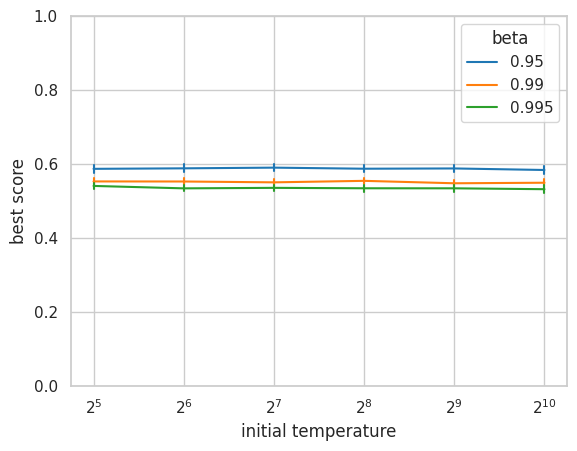

In [631]:
plotBestScoreByHyperparameters(expDF)
plt.ylim(0,1)

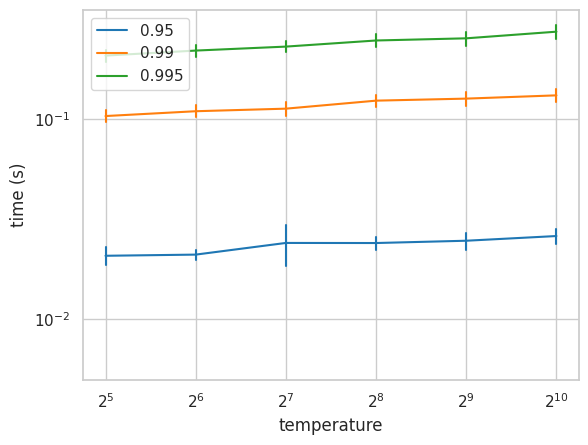

In [633]:
plotTimeByHyperparameters(expDF)
plt.yscale("log")
plt.ylim((0.005, 0.35))
plt.legend(loc = "upper left")

,initialTemperature,beta,initialScore,resultBestScore
cubeID,,,,
113,256,0.95,0.833333,0.333333


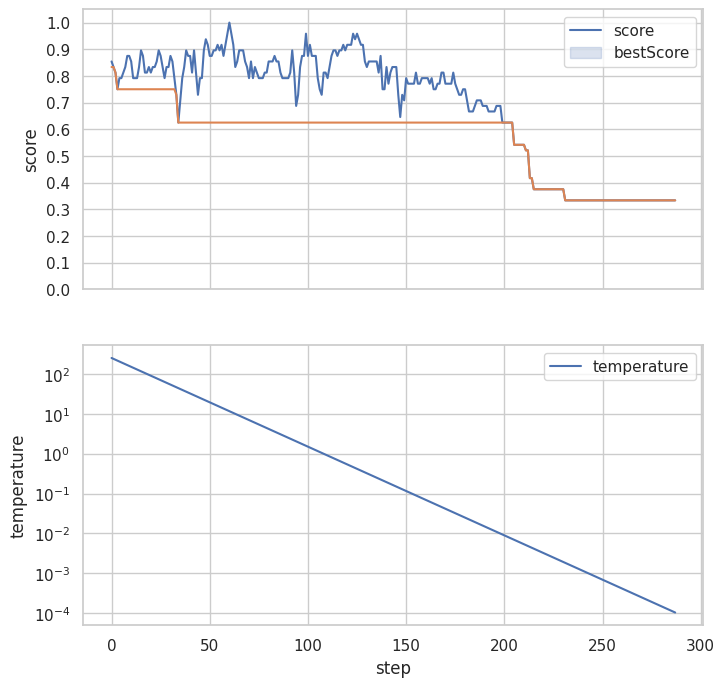

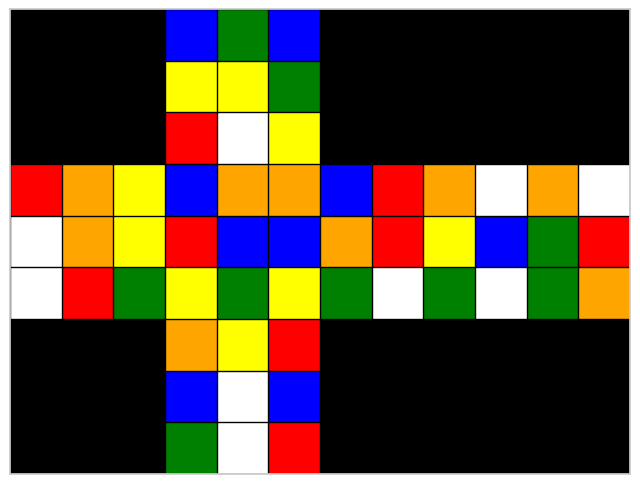

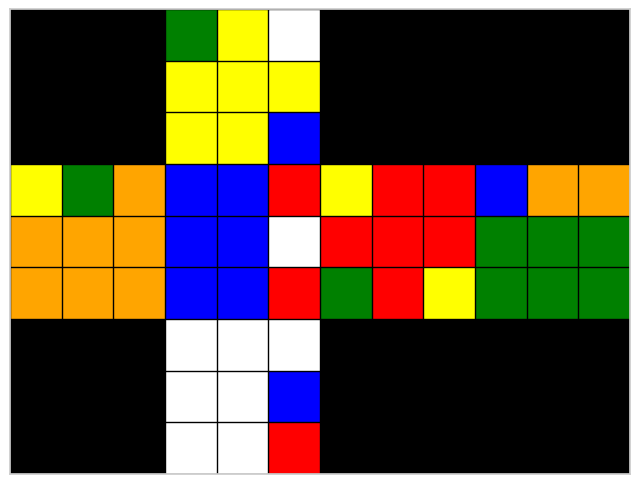

In [641]:
maxReductionILocIndex = expDF["resultBestScore"].argmin()
maxReductionSimulationProgressDF = expDF.iloc[[maxReductionILocIndex]]
display(maxReductionSimulationProgressDF[["initialTemperature", "beta", "initialScore", "resultBestScore"]])
maxReductionSimulationProgressDF = maxReductionSimulationProgressDF[["temperature", "bestScore", "score", "time"]]
maxReductionSimulationProgressDF = maxReductionSimulationProgressDF.explode(["temperature", "bestScore", "score"])
maxReductionSimulationProgressDF["step"] = list(range(maxReductionSimulationProgressDF.shape[0]))
fig, axes = plotSimulationProgress(maxReductionSimulationProgressDF)
axes[0].set_ylim((0,1.05))
axes[0].set_yticks([i/10 for i in range(0,11)])
showCube(cubesSample[expDF.iloc[maxReductionILocIndex].name]["cube"])
showCube(expDF.iloc[maxReductionILocIndex]["resultBestState"])

,initialTemperature,beta,initialScore,resultBestScore
cubeID,,,,
42,128,0.95,0.854167,0.6875


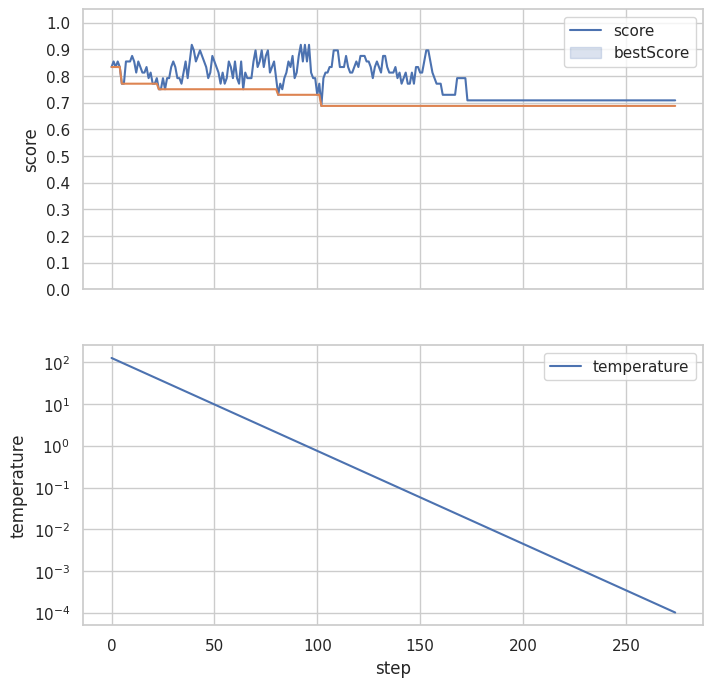

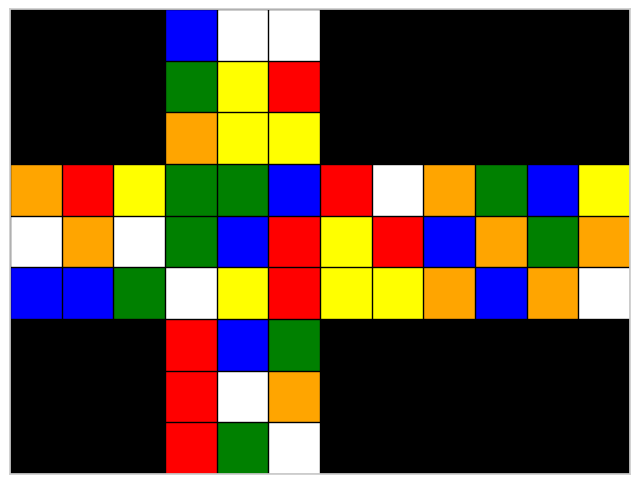

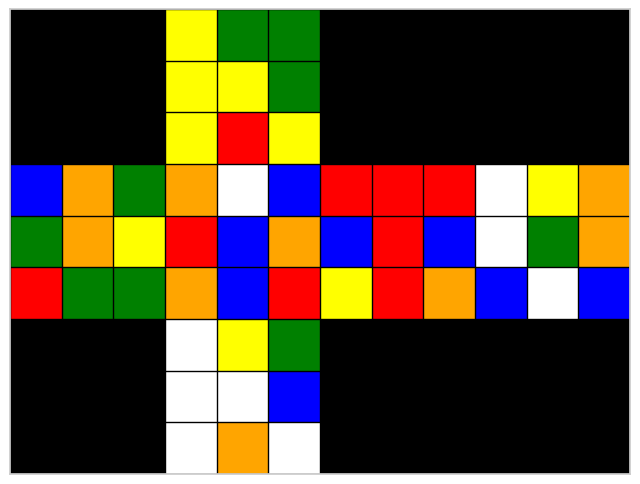

In [642]:
minReductionILocIndex = expDF["resultBestScore"].argmax()
minReductionSimulationProgressDF = expDF.iloc[[minReductionILocIndex]]
display(minReductionSimulationProgressDF[["initialTemperature", "beta", "initialScore", "resultBestScore"]])
minReductionSimulationProgressDF = minReductionSimulationProgressDF[["temperature", "bestScore", "score", "time"]]
minReductionSimulationProgressDF = minReductionSimulationProgressDF.explode(["temperature", "bestScore", "score"])
minReductionSimulationProgressDF["step"] = list(range(minReductionSimulationProgressDF.shape[0]))
fig, axes = plotSimulationProgress(minReductionSimulationProgressDF)
axes[0].set_ylim((0,1.05))
axes[0].set_yticks([i/10 for i in range(0,11)])
showCube(cubesSample[expDF.iloc[minReductionILocIndex].name]["cube"])
showCube(expDF.iloc[minReductionILocIndex]["resultBestState"])

## **Experiment 2**

- States are cube configurations (same as Experiment 1). 
- Transitions correspond to a single movement out of the 18 allowed movements (same as Experiment 1). 
- Energy function represents the number of incorrect colors (same as Experiment 1). 
    - But we amplify energies differences to better distinguish between states

In [646]:
experimentName = "exp2"

In [647]:
neighborsFunctionExp = singleMovementNeighbors
utilityFunctionExp = lambda state: totalIncorrectColors(state, normalize = True)

In [648]:
# Uncomment the lines below if you need to run the experiment again
# resultsExp = runExperiment(
#     cubesSample,
#     simulatedAnnealingHyperparameters, 
#     neighborsFunctionExp, 
#     utilityFunctionExp,
#     energyDifferenceAmplifierFunc = lambda x: x**3,
#     verbose = False
# )

# with open(f"{cubesSampleDir}/{experimentName}-results.pkl", "wb") as f:
#     pkl.dump(resultsExp, f)

resultsFile = open(f"{cubesSampleDir}/{experimentName}-results.pkl", "rb")
resultsExp = pkl.load(resultsFile)
resultsFile.close()

100%|██████████| 200/200 [06:36<00:00,  1.98s/it]


In [649]:
expDF = processExperimentResults(resultsExp)
print(expDF.shape)
expDF.head(1)

(3600, 13)


,initialTemperature,simulationSteps,tolerance,annealingStrat,beta,initialScore,resultBestState,resultBestScore,temperature,score,bestScore,time,transitionSequence
cubeID,,,,,,,,,,,,,
0,1024,1,0.0001,exponential,0.995,0.8125,"[[[0.0, 4.0, 5.0], [0.0, 0.0, 5.0], [2.0, 2.0,...",0.645833,"[1024, 1018.88, 1013.7856, 1008.716672, 1003.6...","[0.875, 0.8541666666666666, 0.8541666666666666...","[0.8125, 0.8125, 0.8125, 0.8125, 0.8125, 0.812...",0.267042,"[D, D, U', F, F, F2, B2, F', R', U, L', U', F'..."


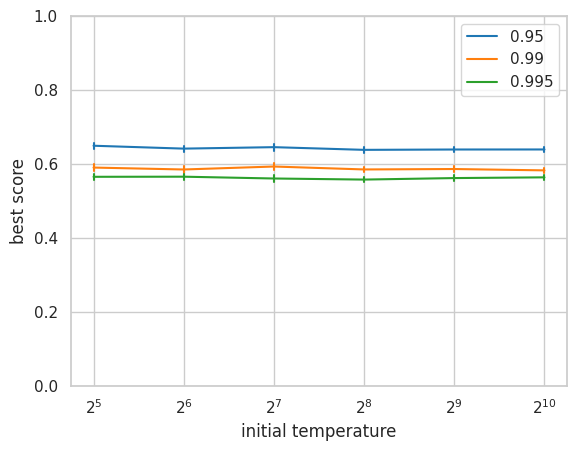

In [651]:
plotBestScoreByHyperparameters(expDF)
plt.ylim(0,1)
plt.legend(loc = "upper right")

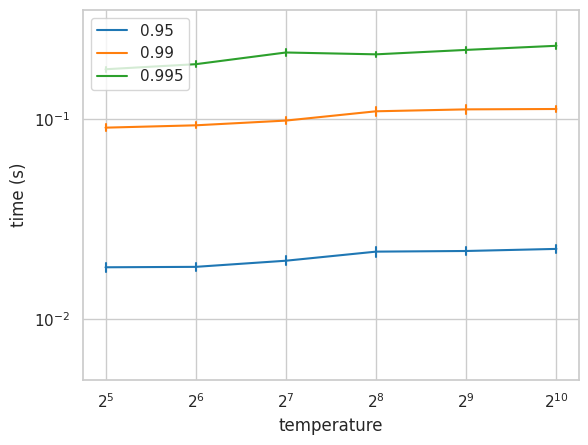

In [650]:
plotTimeByHyperparameters(expDF)
plt.yscale("log")
plt.ylim((0.005, 0.35))
plt.legend(loc = "upper left")

,initialTemperature,beta,initialScore,resultBestScore
cubeID,,,,
162,64,0.995,0.895833,0.375


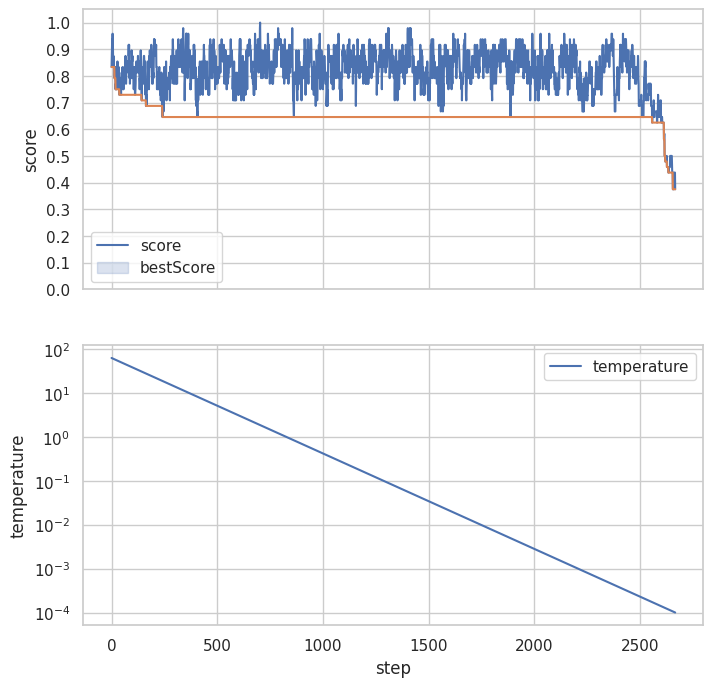

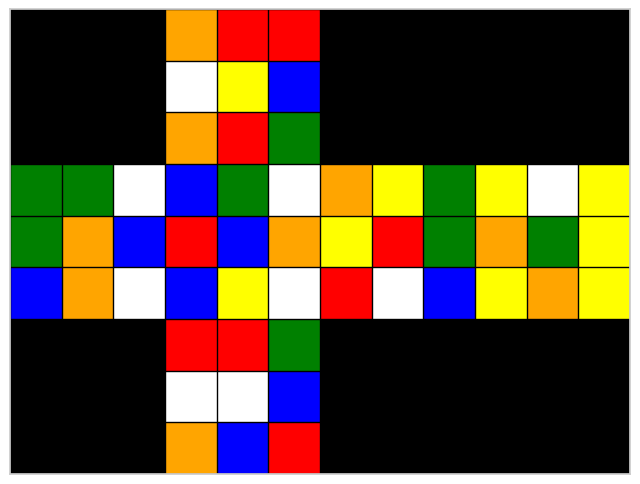

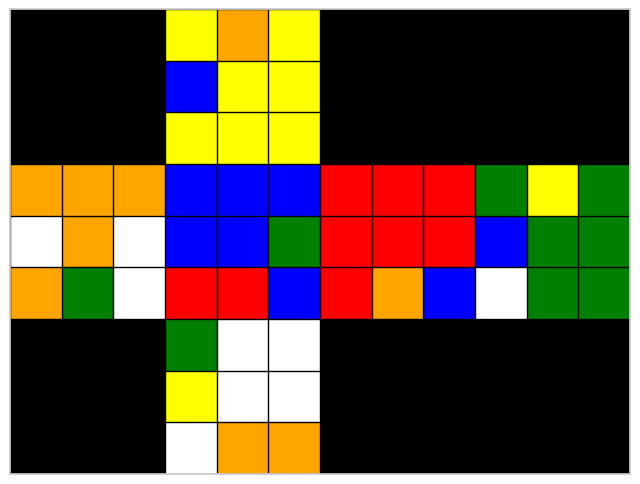

In [652]:
maxReductionILocIndex = expDF["resultBestScore"].argmin()
maxReductionSimulationProgressDF = expDF.iloc[[maxReductionILocIndex]]
display(maxReductionSimulationProgressDF[["initialTemperature", "beta", "initialScore", "resultBestScore"]])
maxReductionSimulationProgressDF = maxReductionSimulationProgressDF[["temperature", "bestScore", "score", "time"]]
maxReductionSimulationProgressDF = maxReductionSimulationProgressDF.explode(["temperature", "bestScore", "score"])
maxReductionSimulationProgressDF["step"] = list(range(maxReductionSimulationProgressDF.shape[0]))
fig, axes = plotSimulationProgress(maxReductionSimulationProgressDF)
axes[0].set_ylim((0,1.05))
axes[0].set_yticks([i/10 for i in range(0,11)])
showCube(cubesSample[expDF.iloc[maxReductionILocIndex].name]["cube"])
showCube(expDF.iloc[maxReductionILocIndex]["resultBestState"])

,initialTemperature,beta,initialScore,resultBestScore
cubeID,,,,
49,32,0.95,0.8125,0.729167


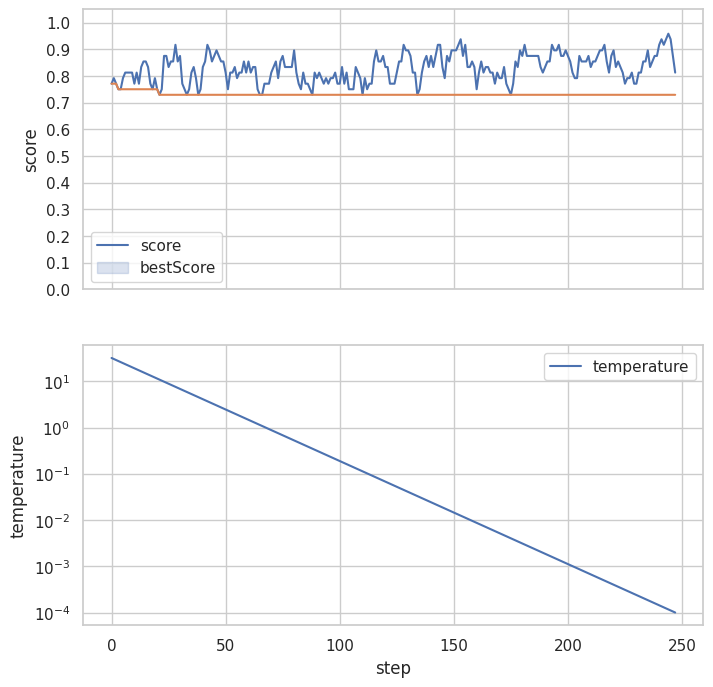

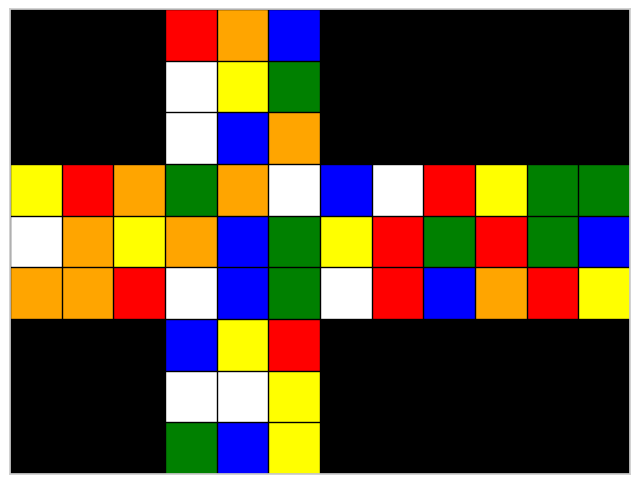

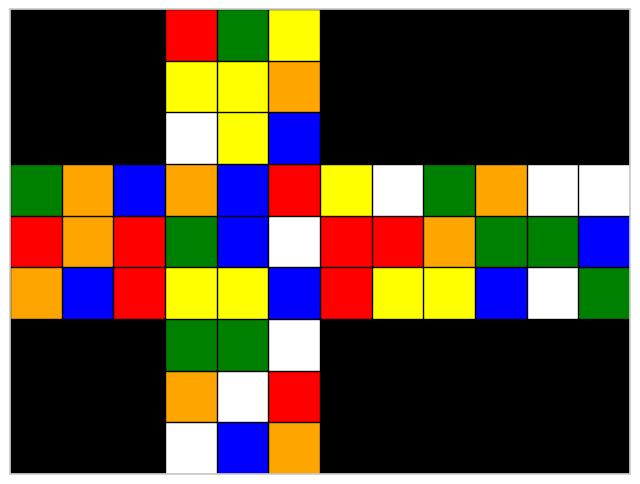

In [653]:
minReductionILocIndex = expDF["resultBestScore"].argmax()
minReductionSimulationProgressDF = expDF.iloc[[minReductionILocIndex]]
display(minReductionSimulationProgressDF[["initialTemperature", "beta", "initialScore", "resultBestScore"]])
minReductionSimulationProgressDF = minReductionSimulationProgressDF[["temperature", "bestScore", "score", "time"]]
minReductionSimulationProgressDF = minReductionSimulationProgressDF.explode(["temperature", "bestScore", "score"])
minReductionSimulationProgressDF["step"] = list(range(minReductionSimulationProgressDF.shape[0]))
fig, axes = plotSimulationProgress(minReductionSimulationProgressDF)
axes[0].set_ylim((0,1.05))
axes[0].set_yticks([i/10 for i in range(0,11)])
showCube(cubesSample[expDF.iloc[minReductionILocIndex].name]["cube"])
showCube(expDF.iloc[minReductionILocIndex]["resultBestState"])

## **Experiment 3**

- States are cube configurations (same as experiments 1 and 2). 
- Transitions correspond to a single movement out of the 18 allowed movements (same as experiments 1 and 2). 
- Energy function represents the number of incorrect cubies (different than experiments 1 and 2). 
    - Same weight for corner and border

In [655]:
experimentName = "exp3"

In [658]:
neighborsFunctionExp = singleMovementNeighbors
utilityFunctionExp = lambda state: weightedWrongPlacedCubies(state, cornerWeight = 1, borderWeight = 1, normalize = True)

In [661]:
# Uncomment the lines below if you need to run the experiment again
# resultsExp = runExperiment(
#     cubesSample,
#     simulatedAnnealingHyperparameters, 
#     neighborsFunctionExp, 
#     utilityFunctionExp,
#     energyDifferenceAmplifierFunc = None,
#     verbose = False
# )

# with open(f"{cubesSampleDir}/{experimentName}-results.pkl", "wb") as f:
#     pkl.dump(resultsExp, f)

resultsFile = open(f"{cubesSampleDir}/{experimentName}-results.pkl", "rb")
resultsExp = pkl.load(resultsFile)
resultsFile.close()

100%|██████████| 200/200 [05:35<00:00,  1.68s/it]


In [662]:
expDF = processExperimentResults(resultsExp)
print(expDF.shape)
expDF.head(1)

(3600, 13)


,initialTemperature,simulationSteps,tolerance,annealingStrat,beta,initialScore,resultBestState,resultBestScore,temperature,score,bestScore,time,transitionSequence
cubeID,,,,,,,,,,,,,
0,1024,1,0.0001,exponential,0.995,1.0,"[[[0.0, 4.0, 3.0], [1.0, 0.0, 3.0], [1.0, 0.0,...",0.7,"[1024, 1018.88, 1013.7856, 1008.716672, 1003.6...","[0.95, 0.95, 1.0, 0.95, 1.0, 1.0, 0.95, 0.9, 0...","[0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.9...",0.213247,"[U2, F2, B', B, B', L', F, D', D2, U, R', F', ..."


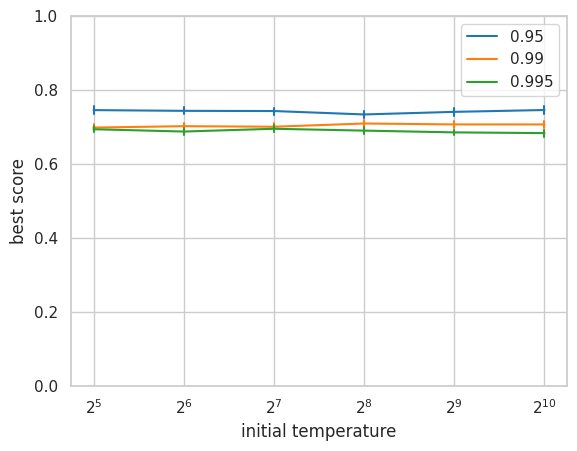

In [664]:
plotBestScoreByHyperparameters(expDF)
plt.ylim(0,1)
plt.legend(loc = "upper right")

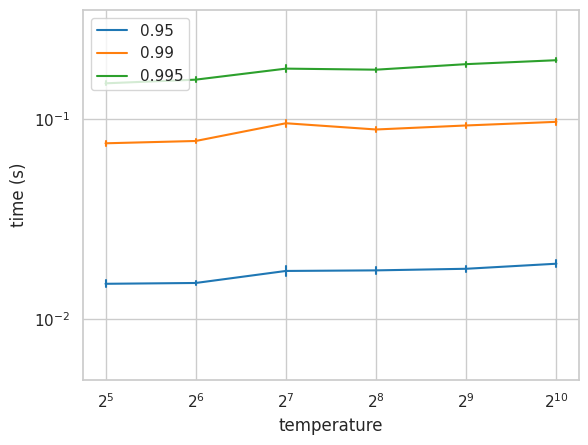

In [665]:
plotTimeByHyperparameters(expDF)
plt.yscale("log")
plt.ylim((0.005, 0.35))
plt.legend(loc = "upper left")

,initialTemperature,beta,initialScore,resultBestScore
cubeID,,,,
125,64,0.99,1.0,0.5


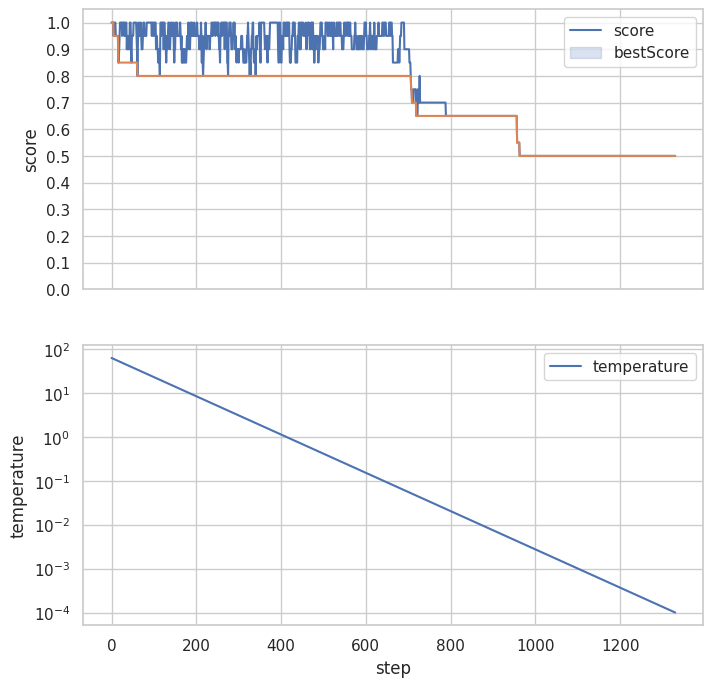

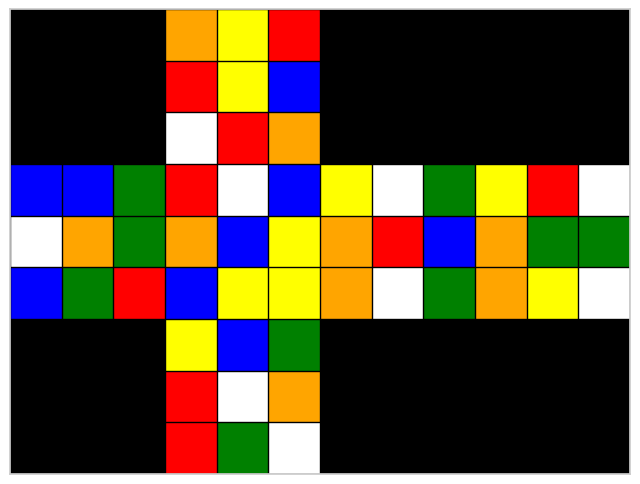

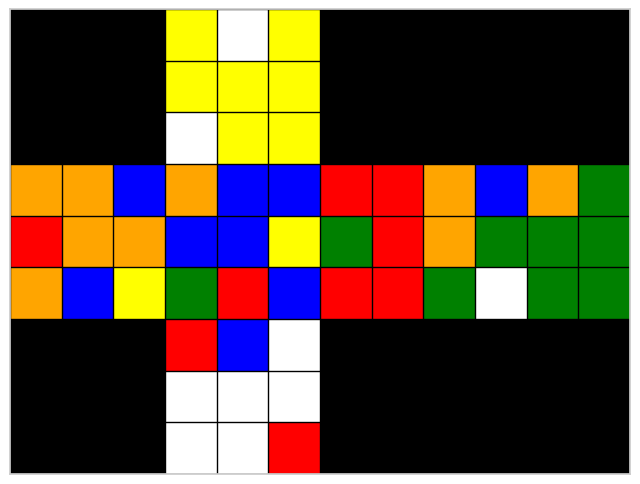

In [666]:
maxReductionILocIndex = expDF["resultBestScore"].argmin()
maxReductionSimulationProgressDF = expDF.iloc[[maxReductionILocIndex]]
display(maxReductionSimulationProgressDF[["initialTemperature", "beta", "initialScore", "resultBestScore"]])
maxReductionSimulationProgressDF = maxReductionSimulationProgressDF[["temperature", "bestScore", "score", "time"]]
maxReductionSimulationProgressDF = maxReductionSimulationProgressDF.explode(["temperature", "bestScore", "score"])
maxReductionSimulationProgressDF["step"] = list(range(maxReductionSimulationProgressDF.shape[0]))
fig, axes = plotSimulationProgress(maxReductionSimulationProgressDF)
axes[0].set_ylim((0,1.05))
axes[0].set_yticks([i/10 for i in range(0,11)])
showCube(cubesSample[expDF.iloc[maxReductionILocIndex].name]["cube"])
showCube(expDF.iloc[maxReductionILocIndex]["resultBestState"])

,initialTemperature,beta,initialScore,resultBestScore
cubeID,,,,
22,32,0.95,0.9,0.85


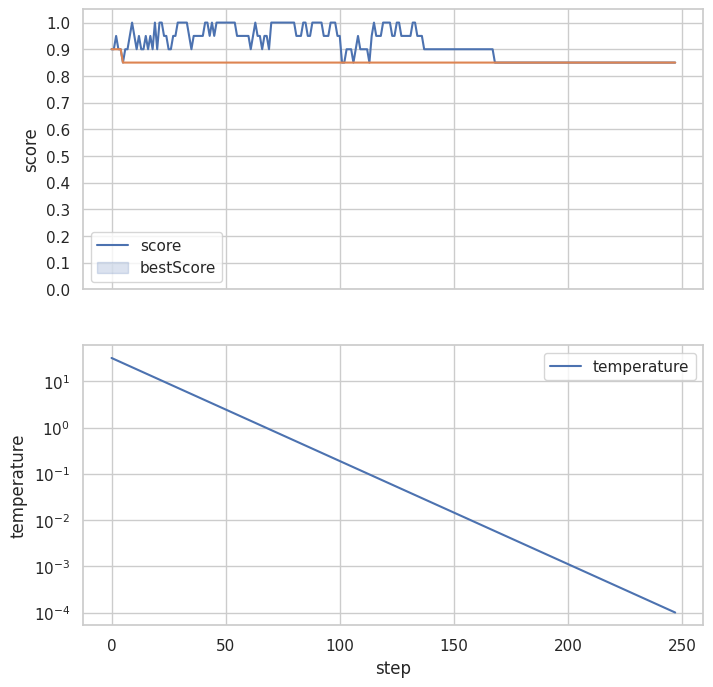

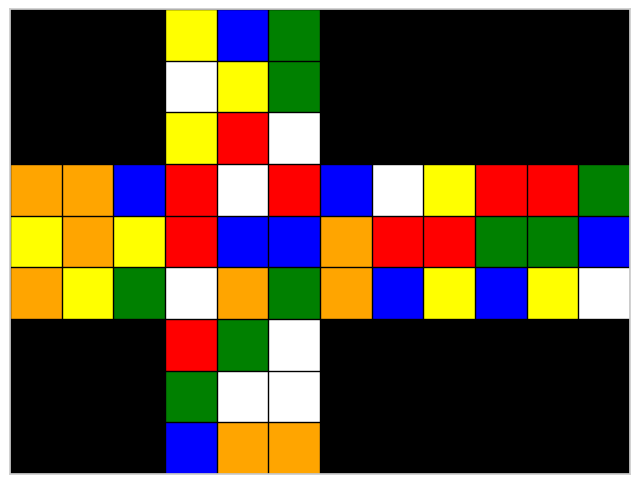

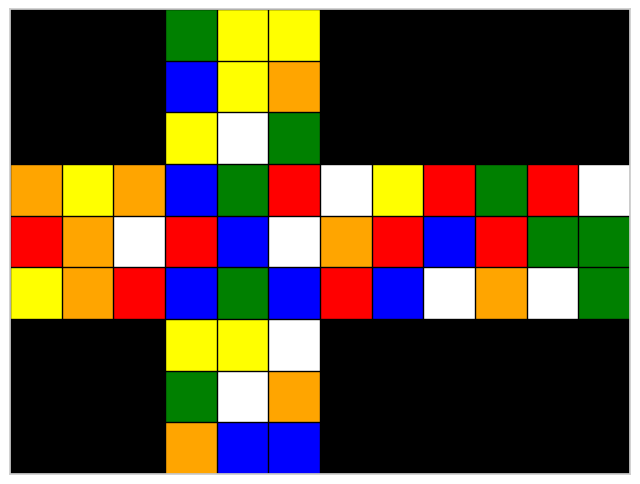

In [667]:
minReductionILocIndex = expDF["resultBestScore"].argmax()
minReductionSimulationProgressDF = expDF.iloc[[minReductionILocIndex]]
display(minReductionSimulationProgressDF[["initialTemperature", "beta", "initialScore", "resultBestScore"]])
minReductionSimulationProgressDF = minReductionSimulationProgressDF[["temperature", "bestScore", "score", "time"]]
minReductionSimulationProgressDF = minReductionSimulationProgressDF.explode(["temperature", "bestScore", "score"])
minReductionSimulationProgressDF["step"] = list(range(minReductionSimulationProgressDF.shape[0]))
fig, axes = plotSimulationProgress(minReductionSimulationProgressDF)
axes[0].set_ylim((0,1.05))
axes[0].set_yticks([i/10 for i in range(0,11)])
showCube(cubesSample[expDF.iloc[minReductionILocIndex].name]["cube"])
showCube(expDF.iloc[minReductionILocIndex]["resultBestState"])

## **Experiment 4**

- States are cube configurations (same as experiments 1, 2 and 3). 
- Transitions correspond to a single movement out of the 18 allowed movements (same as experiments 1, 2 and 3). 
- Energy function represents the number of incorrect cubies (different than experiments 1, 2 and 3). 
    - Corners weight 3x greater than borders weight

In [668]:
experimentName = "exp4"

In [669]:
neighborsFunctionExp = singleMovementNeighbors
utilityFunctionExp = lambda state: weightedWrongPlacedCubies(state, cornerWeight = 3, borderWeight = 1, normalize = True)

In [670]:
# Uncomment the lines below if you need to run the experiment again
# resultsExp = runExperiment(
#     cubesSample,
#     simulatedAnnealingHyperparameters, 
#     neighborsFunctionExp, 
#     utilityFunctionExp,
#     energyDifferenceAmplifierFunc = None,
#     verbose = False
# )

# with open(f"{cubesSampleDir}/{experimentName}-results.pkl", "wb") as f:
#     pkl.dump(resultsExp, f)

resultsFile = open(f"{cubesSampleDir}/{experimentName}-results.pkl", "rb")
resultsExp = pkl.load(resultsFile)
resultsFile.close()

100%|██████████| 200/200 [05:33<00:00,  1.67s/it]


In [673]:
expDF = processExperimentResults(resultsExp)
print(expDF.shape)
expDF.head(1)

(3600, 13)


,initialTemperature,simulationSteps,tolerance,annealingStrat,beta,initialScore,resultBestState,resultBestScore,temperature,score,bestScore,time,transitionSequence
cubeID,,,,,,,,,,,,,
0,1024,1,0.0001,exponential,0.995,1.0,"[[[1.0, 0.0, 3.0], [0.0, 0.0, 4.0], [1.0, 3.0,...",0.638889,"[1024, 1018.88, 1013.7856, 1008.716672, 1003.6...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.972...",0.204328,"[D2, F, B', U2, U', R', B2, D, R2, D2, L, R, D..."


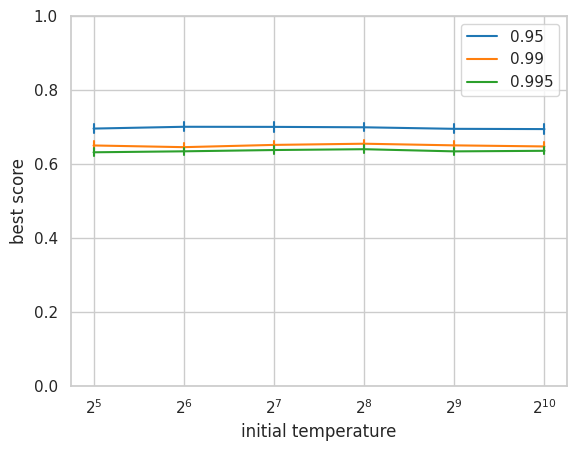

In [674]:
plotBestScoreByHyperparameters(expDF)
plt.ylim(0,1)
plt.legend(loc = "upper right")

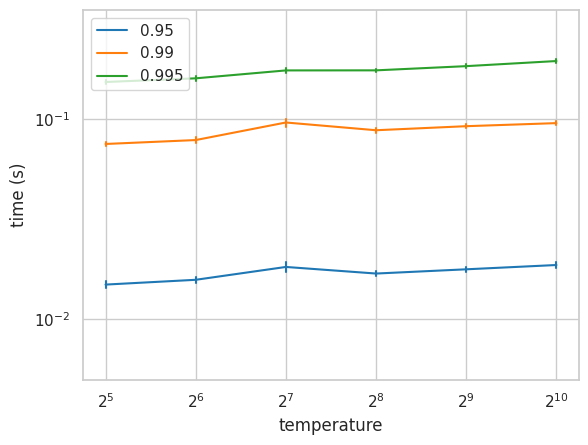

In [675]:
plotTimeByHyperparameters(expDF)
plt.yscale("log")
plt.ylim((0.005, 0.35))
plt.legend(loc = "upper left")

,initialTemperature,beta,initialScore,resultBestScore
cubeID,,,,
110,32,0.995,0.972222,0.416667


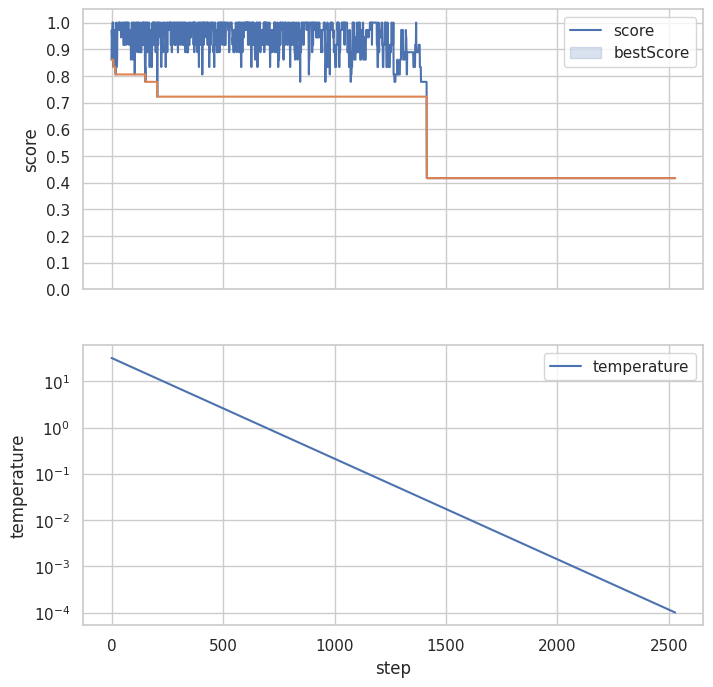

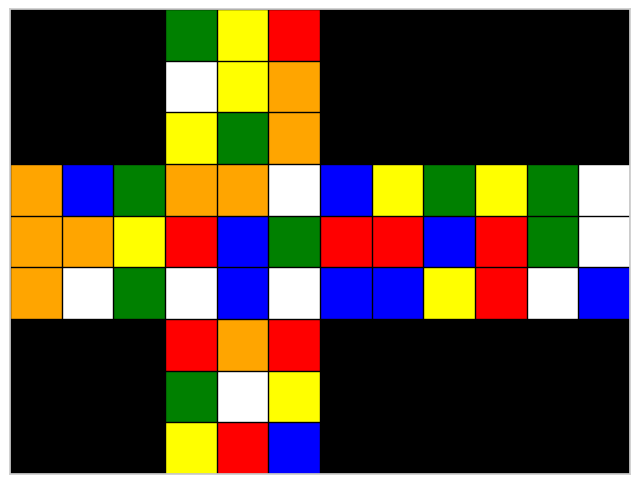

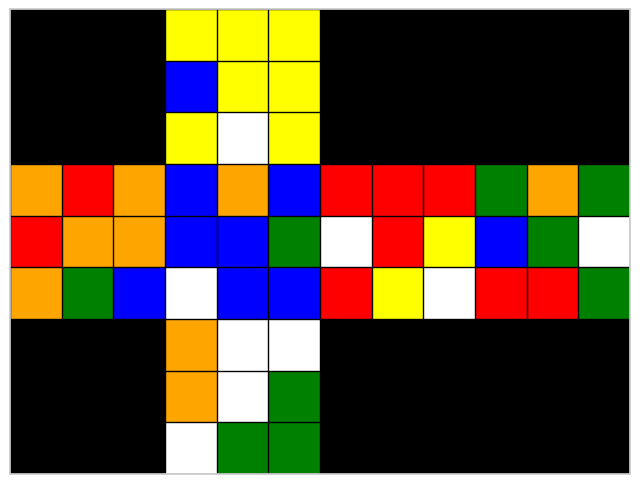

In [676]:
maxReductionILocIndex = expDF["resultBestScore"].argmin()
maxReductionSimulationProgressDF = expDF.iloc[[maxReductionILocIndex]]
display(maxReductionSimulationProgressDF[["initialTemperature", "beta", "initialScore", "resultBestScore"]])
maxReductionSimulationProgressDF = maxReductionSimulationProgressDF[["temperature", "bestScore", "score", "time"]]
maxReductionSimulationProgressDF = maxReductionSimulationProgressDF.explode(["temperature", "bestScore", "score"])
maxReductionSimulationProgressDF["step"] = list(range(maxReductionSimulationProgressDF.shape[0]))
fig, axes = plotSimulationProgress(maxReductionSimulationProgressDF)
axes[0].set_ylim((0,1.05))
axes[0].set_yticks([i/10 for i in range(0,11)])
showCube(cubesSample[expDF.iloc[maxReductionILocIndex].name]["cube"])
showCube(expDF.iloc[maxReductionILocIndex]["resultBestState"])

,initialTemperature,beta,initialScore,resultBestScore
cubeID,,,,
18,64,0.95,1.0,0.833333


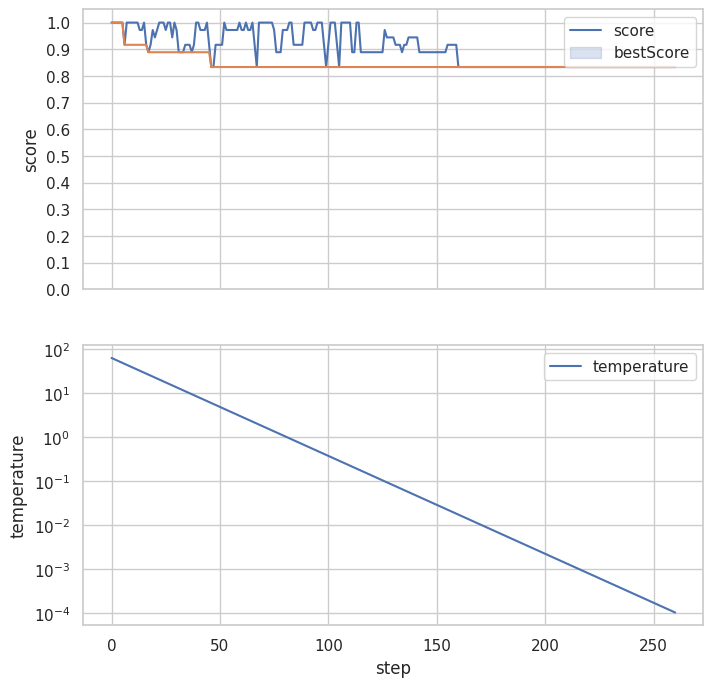

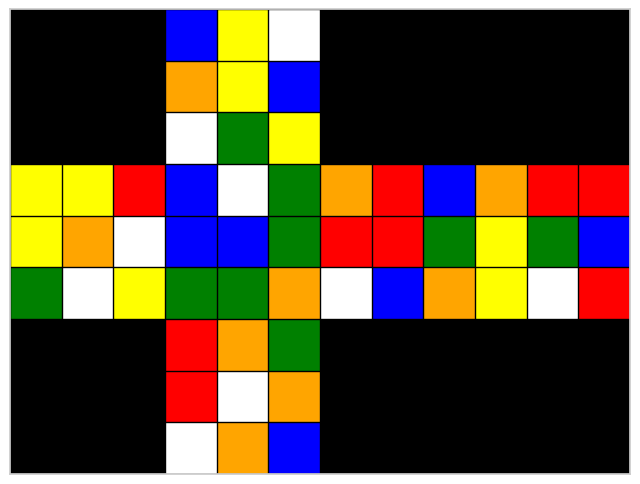

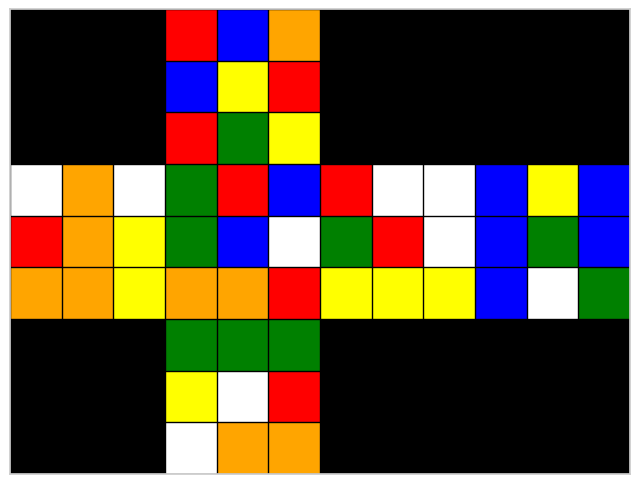

In [677]:
minReductionILocIndex = expDF["resultBestScore"].argmax()
minReductionSimulationProgressDF = expDF.iloc[[minReductionILocIndex]]
display(minReductionSimulationProgressDF[["initialTemperature", "beta", "initialScore", "resultBestScore"]])
minReductionSimulationProgressDF = minReductionSimulationProgressDF[["temperature", "bestScore", "score", "time"]]
minReductionSimulationProgressDF = minReductionSimulationProgressDF.explode(["temperature", "bestScore", "score"])
minReductionSimulationProgressDF["step"] = list(range(minReductionSimulationProgressDF.shape[0]))
fig, axes = plotSimulationProgress(minReductionSimulationProgressDF)
axes[0].set_ylim((0,1.05))
axes[0].set_yticks([i/10 for i in range(0,11)])
showCube(cubesSample[expDF.iloc[minReductionILocIndex].name]["cube"])
showCube(expDF.iloc[minReductionILocIndex]["resultBestState"])

## **Experiment 5**

- States are cube configurations (same as experiments 1, 2, 3 and 4). 
- Transitions correspond to a single movement out of the 18 allowed movements (same as experiments 1, 2, 3 and 4). 
- Energy function represents the number of incorrect cubies (different than experiments 1, 2, 3 and 4). 
    - Borders weight 3x greater than corners weight

In [678]:
experimentName = "exp5"

In [679]:
neighborsFunctionExp = singleMovementNeighbors
utilityFunctionExp = lambda state: weightedWrongPlacedCubies(state, cornerWeight = 1, borderWeight = 3, normalize = True)

In [680]:
# Uncomment the lines below if you need to run the experiment again
# resultsExp = runExperiment(
#     cubesSample,
#     simulatedAnnealingHyperparameters, 
#     neighborsFunctionExp, 
#     utilityFunctionExp,
#     energyDifferenceAmplifierFunc = None,
#     verbose = False
# )

# with open(f"{cubesSampleDir}/{experimentName}-results.pkl", "wb") as f:
#     pkl.dump(resultsExp, f)

resultsFile = open(f"{cubesSampleDir}/{experimentName}-results.pkl", "rb")
resultsExp = pkl.load(resultsFile)
resultsFile.close()

100%|██████████| 200/200 [05:29<00:00,  1.65s/it]


In [681]:
expDF = processExperimentResults(resultsExp)
print(expDF.shape)
expDF.head(1)

(3600, 13)


,initialTemperature,simulationSteps,tolerance,annealingStrat,beta,initialScore,resultBestState,resultBestScore,temperature,score,bestScore,time,transitionSequence
cubeID,,,,,,,,,,,,,
0,1024,1,0.0001,exponential,0.995,1.0,"[[[5.0, 1.0, 5.0], [0.0, 0.0, 2.0], [1.0, 0.0,...",0.727273,"[1024, 1018.88, 1013.7856, 1008.716672, 1003.6...","[0.9318181818181818, 0.9318181818181818, 0.931...","[0.9318181818181818, 0.9318181818181818, 0.931...",0.277202,"[B, F2, F', F', F2, R2, L, U', F, D2, R, F', R..."


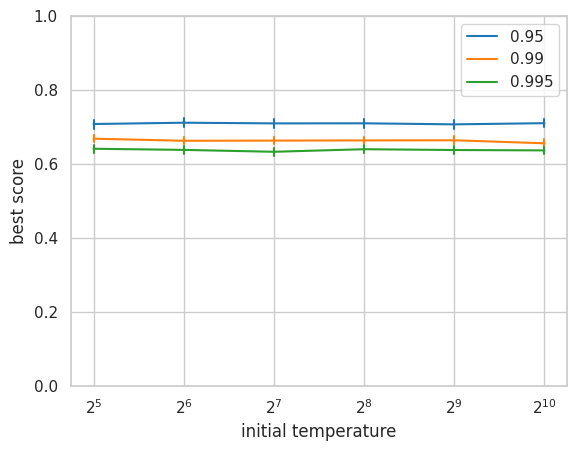

In [682]:
plotBestScoreByHyperparameters(expDF)
plt.ylim(0,1)
plt.legend(loc = "upper right")

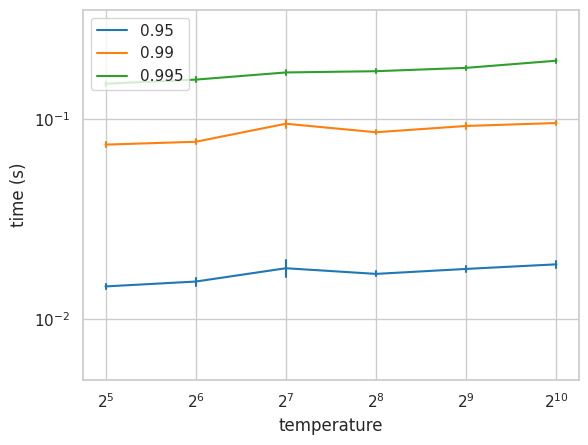

In [683]:
plotTimeByHyperparameters(expDF)
plt.yscale("log")
plt.ylim((0.005, 0.35))
plt.legend(loc = "upper left")

,initialTemperature,beta,initialScore,resultBestScore
cubeID,,,,
79,512,0.995,0.909091,0.431818


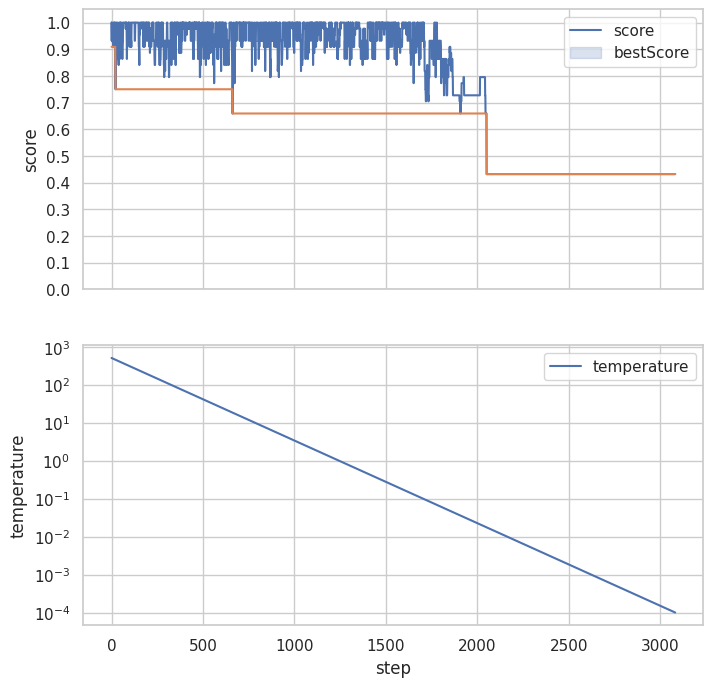

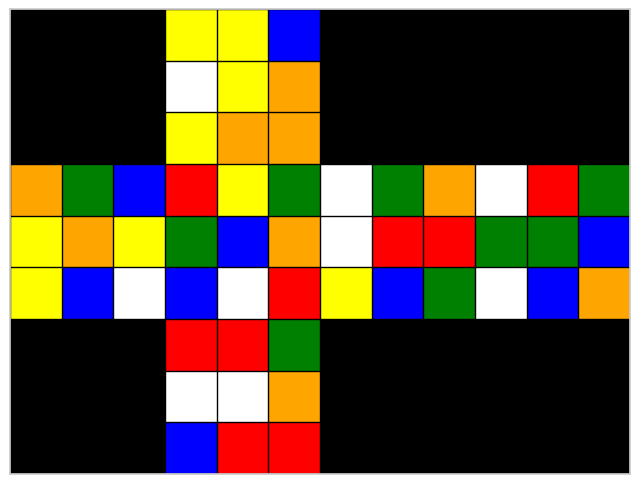

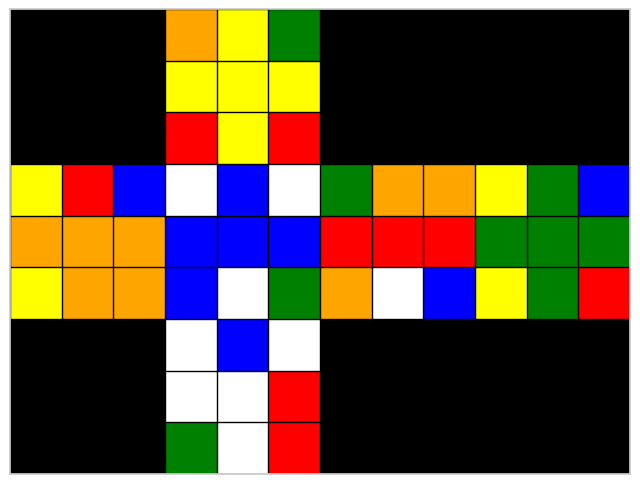

In [684]:
maxReductionILocIndex = expDF["resultBestScore"].argmin()
maxReductionSimulationProgressDF = expDF.iloc[[maxReductionILocIndex]]
display(maxReductionSimulationProgressDF[["initialTemperature", "beta", "initialScore", "resultBestScore"]])
maxReductionSimulationProgressDF = maxReductionSimulationProgressDF[["temperature", "bestScore", "score", "time"]]
maxReductionSimulationProgressDF = maxReductionSimulationProgressDF.explode(["temperature", "bestScore", "score"])
maxReductionSimulationProgressDF["step"] = list(range(maxReductionSimulationProgressDF.shape[0]))
fig, axes = plotSimulationProgress(maxReductionSimulationProgressDF)
axes[0].set_ylim((0,1.05))
axes[0].set_yticks([i/10 for i in range(0,11)])
showCube(cubesSample[expDF.iloc[maxReductionILocIndex].name]["cube"])
showCube(expDF.iloc[maxReductionILocIndex]["resultBestState"])

,initialTemperature,beta,initialScore,resultBestScore
cubeID,,,,
14,32,0.95,0.931818,0.840909


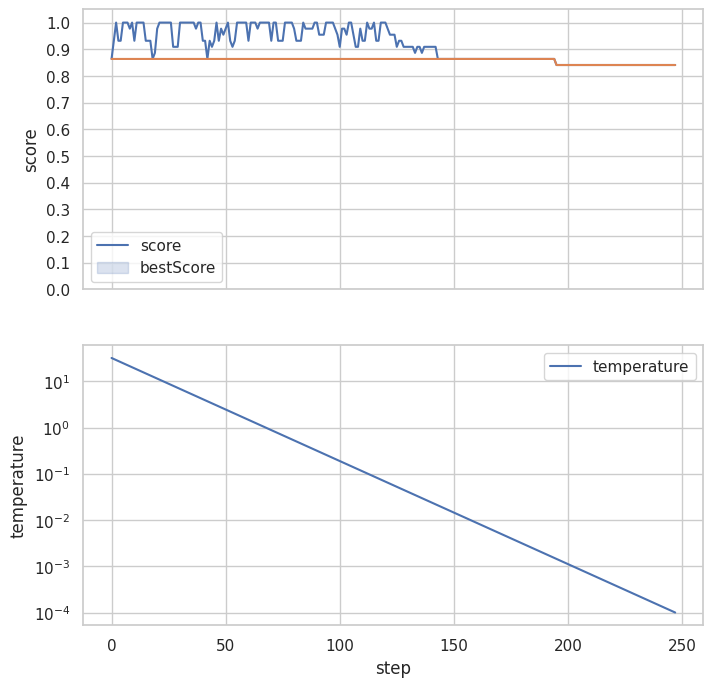

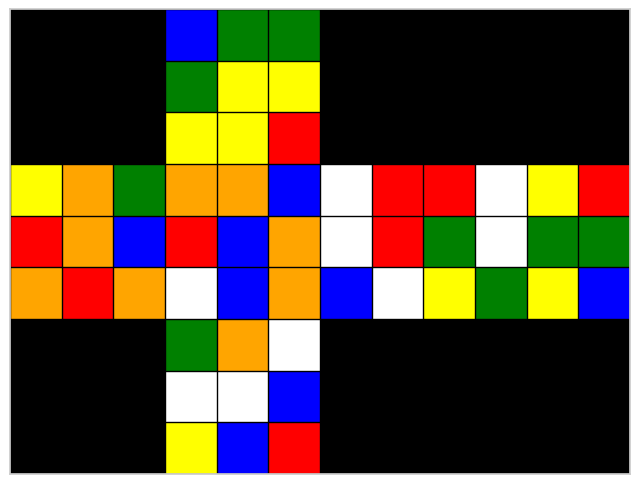

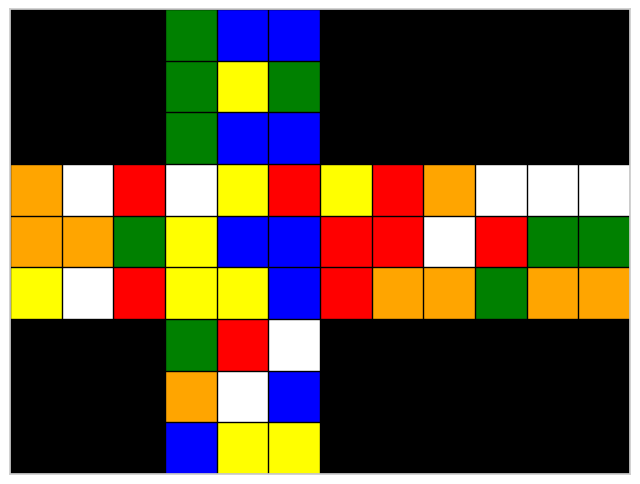

In [685]:
minReductionILocIndex = expDF["resultBestScore"].argmax()
minReductionSimulationProgressDF = expDF.iloc[[minReductionILocIndex]]
display(minReductionSimulationProgressDF[["initialTemperature", "beta", "initialScore", "resultBestScore"]])
minReductionSimulationProgressDF = minReductionSimulationProgressDF[["temperature", "bestScore", "score", "time"]]
minReductionSimulationProgressDF = minReductionSimulationProgressDF.explode(["temperature", "bestScore", "score"])
minReductionSimulationProgressDF["step"] = list(range(minReductionSimulationProgressDF.shape[0]))
fig, axes = plotSimulationProgress(minReductionSimulationProgressDF)
axes[0].set_ylim((0,1.05))
axes[0].set_yticks([i/10 for i in range(0,11)])
showCube(cubesSample[expDF.iloc[minReductionILocIndex].name]["cube"])
showCube(expDF.iloc[minReductionILocIndex]["resultBestState"])

## **Experiment 6**

- States are cube configurations
- Transitions correspond to a single movement out of the 18 allowed movements
- Energy function represents the number of incorrect cubies pairs

In [770]:
experimentName = "exp6"

In [829]:
neighborsFunctionExp = singleMovementNeighbors
utilityFunctionExp = lambda state: wrongCubiePairs(state, normalize = True)

In [835]:
# Uncomment the lines below if you need to run the experiment again
# resultsExp = runExperiment(
#     cubesSample,
#     simulatedAnnealingHyperparameters, 
#     neighborsFunctionExp, 
#     utilityFunctionExp,
#     energyDifferenceAmplifierFunc = None,
#     verbose = False
# )

# with open(f"{cubesSampleDir}/{experimentName}-results.pkl", "wb") as f:
#     pkl.dump(resultsExp, f)

resultsFile = open(f"{cubesSampleDir}/{experimentName}-results.pkl", "rb")
resultsExp = pkl.load(resultsFile)
resultsFile.close()

100%|██████████| 200/200 [1:22:41<00:00, 24.81s/it]


In [838]:
expDF = processExperimentResults(resultsExp)
print(expDF.shape)
expDF.head(1)

(3600, 13)


,initialTemperature,simulationSteps,tolerance,annealingStrat,beta,initialScore,resultBestState,resultBestScore,temperature,score,bestScore,time,transitionSequence
cubeID,,,,,,,,,,,,,
0,1024,1,0.0001,exponential,0.995,0.875,"[[[0.0, 5.0, 5.0], [4.0, 0.0, 0.0], [1.0, 0.0,...",0.625,"[1024, 1018.88, 1013.7856, 1008.716672, 1003.6...","[0.9166666666666666, 0.9166666666666666, 0.895...","[0.875, 0.875, 0.875, 0.875, 0.875, 0.85416666...",2.897916,"[D, L, U, B', L2, R', R, D2, B2, U', L, U, D2,..."


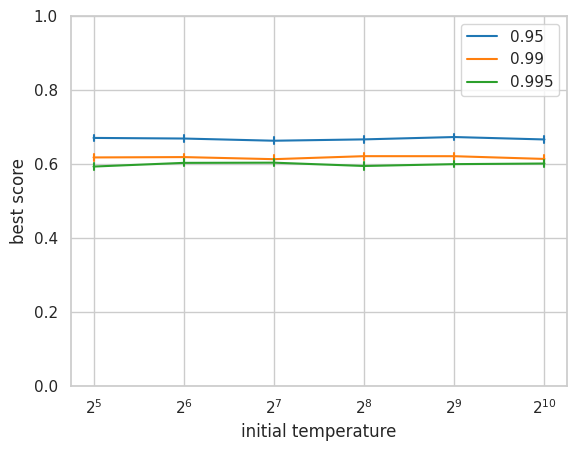

In [839]:
plotBestScoreByHyperparameters(expDF)
plt.ylim(0,1)
plt.legend(loc = "upper right")

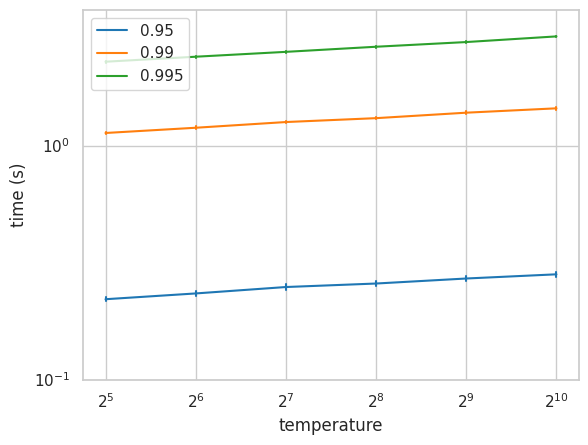

In [1037]:
plotTimeByHyperparameters(expDF)
plt.yscale("log")
plt.ylim((0.1, 3.8))
plt.legend(loc = "upper left")

,initialTemperature,beta,initialScore,resultBestScore
cubeID,,,,
159,128,0.995,0.916667,0.395833


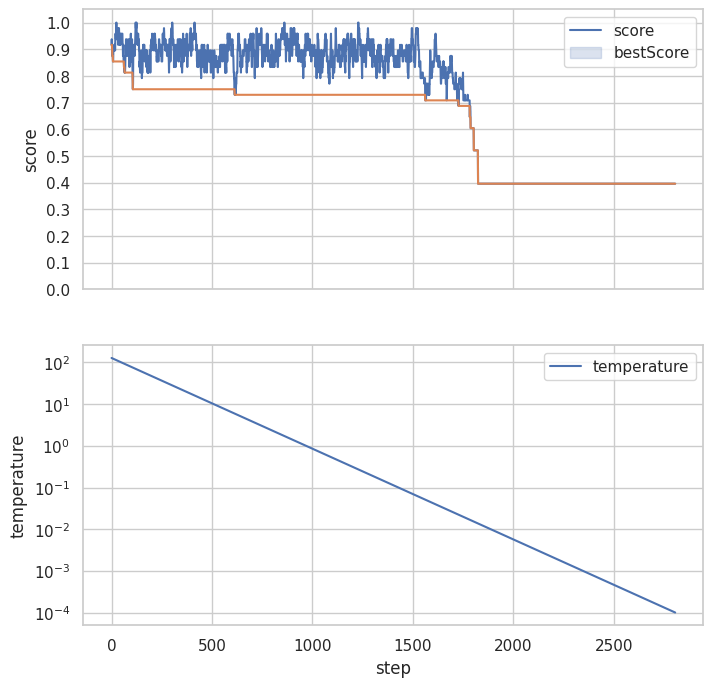

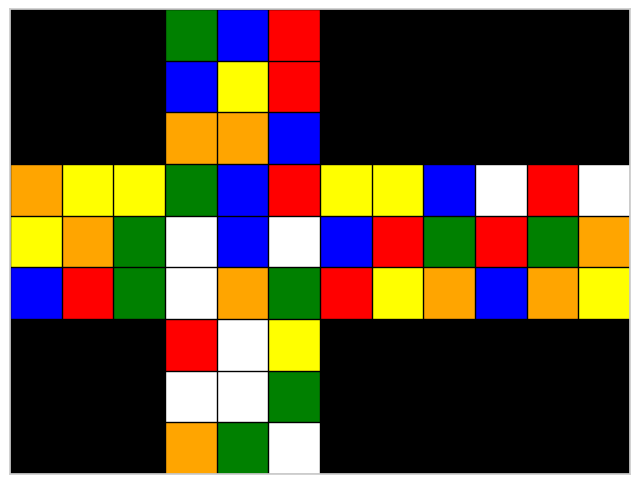

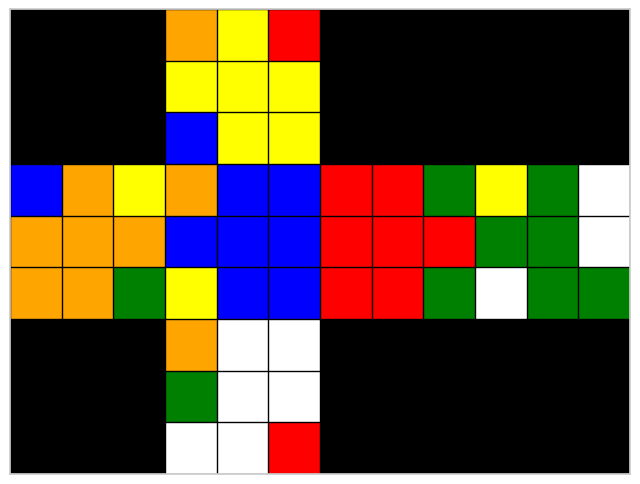

In [841]:
maxReductionILocIndex = expDF["resultBestScore"].argmin()
maxReductionSimulationProgressDF = expDF.iloc[[maxReductionILocIndex]]
display(maxReductionSimulationProgressDF[["initialTemperature", "beta", "initialScore", "resultBestScore"]])
maxReductionSimulationProgressDF = maxReductionSimulationProgressDF[["temperature", "bestScore", "score", "time"]]
maxReductionSimulationProgressDF = maxReductionSimulationProgressDF.explode(["temperature", "bestScore", "score"])
maxReductionSimulationProgressDF["step"] = list(range(maxReductionSimulationProgressDF.shape[0]))
fig, axes = plotSimulationProgress(maxReductionSimulationProgressDF)
axes[0].set_ylim((0,1.05))
axes[0].set_yticks([i/10 for i in range(0,11)])
showCube(cubesSample[expDF.iloc[maxReductionILocIndex].name]["cube"])
showCube(expDF.iloc[maxReductionILocIndex]["resultBestState"])

,initialTemperature,beta,initialScore,resultBestScore
cubeID,,,,
14,32,0.95,0.931818,0.840909


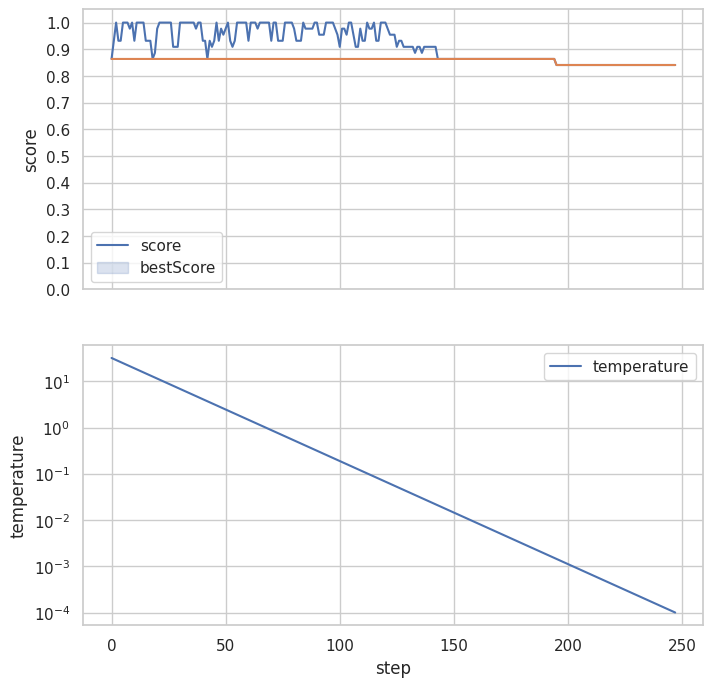

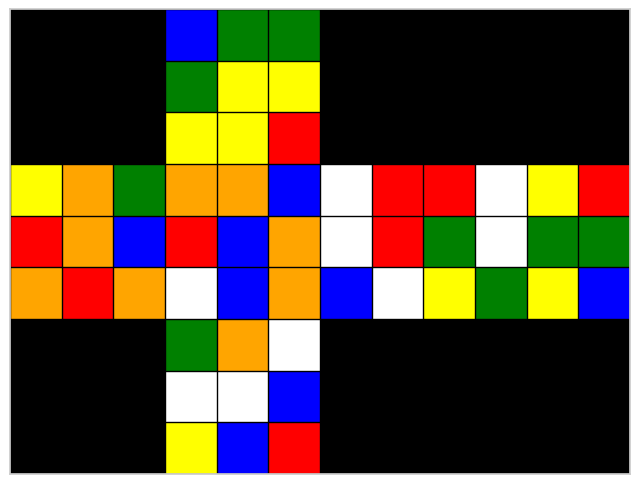

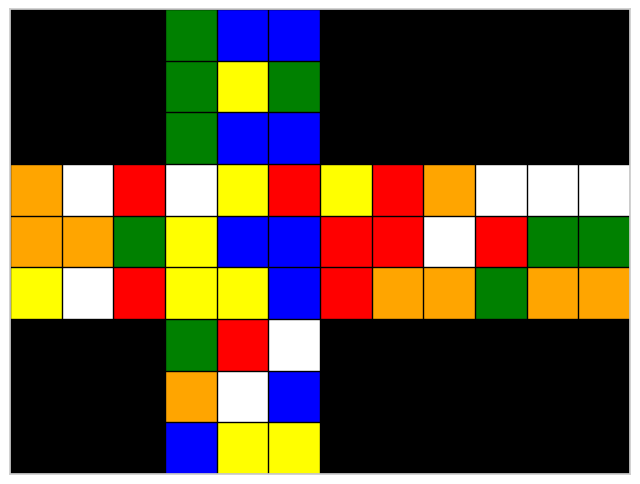

In [ ]:
minReductionILocIndex = expDF["resultBestScore"].argmax()
minReductionSimulationProgressDF = expDF.iloc[[minReductionILocIndex]]
display(minReductionSimulationProgressDF[["initialTemperature", "beta", "initialScore", "resultBestScore"]])
minReductionSimulationProgressDF = minReductionSimulationProgressDF[["temperature", "bestScore", "score", "time"]]
minReductionSimulationProgressDF = minReductionSimulationProgressDF.explode(["temperature", "bestScore", "score"])
minReductionSimulationProgressDF["step"] = list(range(minReductionSimulationProgressDF.shape[0]))
fig, axes = plotSimulationProgress(minReductionSimulationProgressDF)
axes[0].set_ylim((0,1.05))
axes[0].set_yticks([i/10 for i in range(0,11)])
showCube(cubesSample[expDF.iloc[minReductionILocIndex].name]["cube"])
showCube(expDF.iloc[minReductionILocIndex]["resultBestState"])

## **Experiment 7**

- States are movement sequences
- Transitions correspond to a single movement out of the 19 allowed movements (it is possible to undo the last movement)
- Energy function represents the number of incorrect colors

In [789]:
experimentName = "exp7"

In [790]:
neighborsFunctionExp = sequentialMovementNeighbors
def utilityFunctionExp(state, **kwargs):
    movements = state[0]
    cube = state[3]
    return totalIncorrectColors(cube, normalize = True)

In [791]:
# Uncomment the lines below if you need to run the experiment again
# resultsExp = []
# for sequenceLength in [128, 256, 512, 1024]:
#     results = runExperiment(
#         cubesSample,
#         simulatedAnnealingHyperparameters, 
#         neighborsFunctionExp, 
#         utilityFunctionExp,
#         initialState = [[], 0, sequenceLength],
#         verbose = False
#     )
#     resultsExp.append({"sequenceLength": sequenceLength, "results": results})

# with open(f"{cubesSampleDir}/{experimentName}-results.pkl", "wb") as f:
#     pkl.dump(resultsExp, f)

resultsFile = open(f"{cubesSampleDir}/{experimentName}-results.pkl", "rb")
resultsExp = pkl.load(resultsFile)
resultsFile.close()

100%|██████████| 200/200 [11:52<00:00,  3.56s/it]


In [792]:
expDF = []
for results in resultsExp:
    expDF.append(processExperimentResults(results["results"]))
    expDF[-1]["movementSequenceLength"] = results["sequenceLength"]
expDF = pd.concat(expDF)
print(expDF.shape)
expDF.head(1)

(14400, 14)


,initialTemperature,simulationSteps,tolerance,annealingStrat,beta,initialScore,resultBestState,resultBestScore,temperature,score,bestScore,time,transitionSequence,movementSequenceLength
cubeID,,,,,,,,,,,,,,
0,1024,1,0.0001,exponential,0.995,0.8125,"[[U, R', F', B, D, U, F', D', L, F', R2, F', R...",0.6875,"[1024, 1018.88, 1013.7856, 1008.716672, 1003.6...","[0.7708333333333334, 0.7708333333333334, 0.729...","[0.7708333333333334, 0.7708333333333334, 0.729...",0.158882,"[U, R', F', B, D, U, F', R2, [R2], D', L, F', ...",128


(0.0, 1.0)

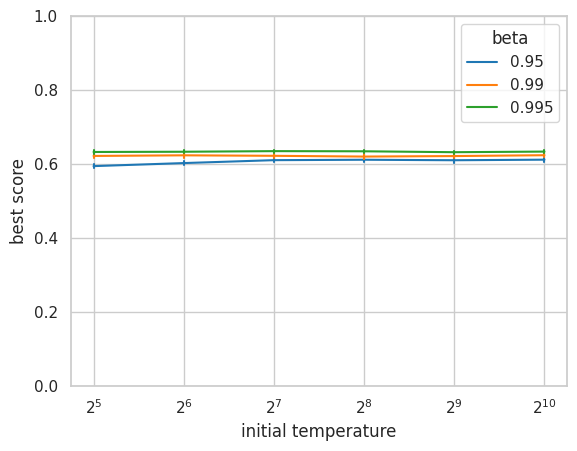

In [793]:
plotBestScoreByHyperparameters(expDF)
plt.ylim(0,1)

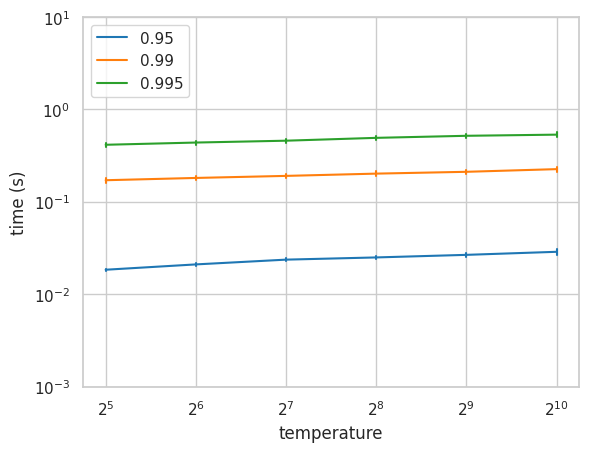

In [794]:
plotTimeByHyperparameters(expDF)
plt.yscale("log")
plt.ylim((0.001, 10))
plt.legend(loc = "upper left")

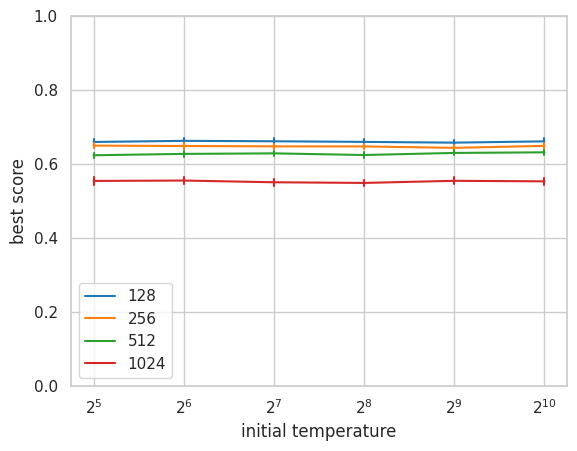

In [797]:
plotBestScoreByMovementSequenceLength(expDF)
plt.ylim(0,1)
plt.legend(loc = "lower left")

,initialTemperature,beta,initialScore,resultBestScore
cubeID,,,,
43,32,0.99,0.8125,0.375


[["L'", 'L2', 'L', 'B2', 'F2', "R'", 'F', 'B2', 'R2', "R'", 'F2', 'B', 'F2', 'B2', 'B', 'B2', 'D', 'L2', 'B', 'B', "D'", 'B2', "B'", "R'", 'L2', 'B', 'U2', "D'", 'B2', 'R2', "D'", 'F2', 'D', "F'", 'D', 'U', 'R', "L'", "D'", 'L2', "B'", 'D', "B'", 'B', "U'", 'R2', 'B2', "U'", 'F2', 'L2', "R'", "F'", 'F', 'U', 'L', "D'", 'F2', "L'", 'R', "L'", 'U2', "D'", 'U2', 'U2', 'R2', 'R', 'U', 'L2', 'D2', 'U2', 'L2', 'B', 'U', "F'", 'F2', "L'", 'B2', 'F2', 'D', 'R', "D'", "L'", 'L2', "U'", "U'", 'L2', "R'", "D'", "F'", 'U2', "D'", "R'", "R'", "B'", 'D2', 'U2', 'U2', 'F', "L'", 'D2', 'B', "D'", 'L2', 'U2', "D'", 'F', 'R2', 'D', "F'", "L'", 'U2', 'D', "B'", "B'", 'U2', "L'", 'R', 'U2', 'D', 'F2', 'L', 'D2', "D'", 'F2', "U'", 'D', 'D2', 'L2', 'U2', 'F', "R'", 'D2', 'U2', 'F2', "U'", 'B2', 'D', 'F2', 'D2', 'F2', 'L2', 'B2', 'B2', 'D', "F'", 'F2', "R'", 'B', "D'", 'D2', 'U', "U'", 'L', 'B2', 'D', 'B', 'R2', 'U2', 'F', "L'", 'D2', 'D', "U'", 'R', "L'", 'D2', "U'", 'L2', "R'", "U'", "D'", 'D2', "L'", "L'"

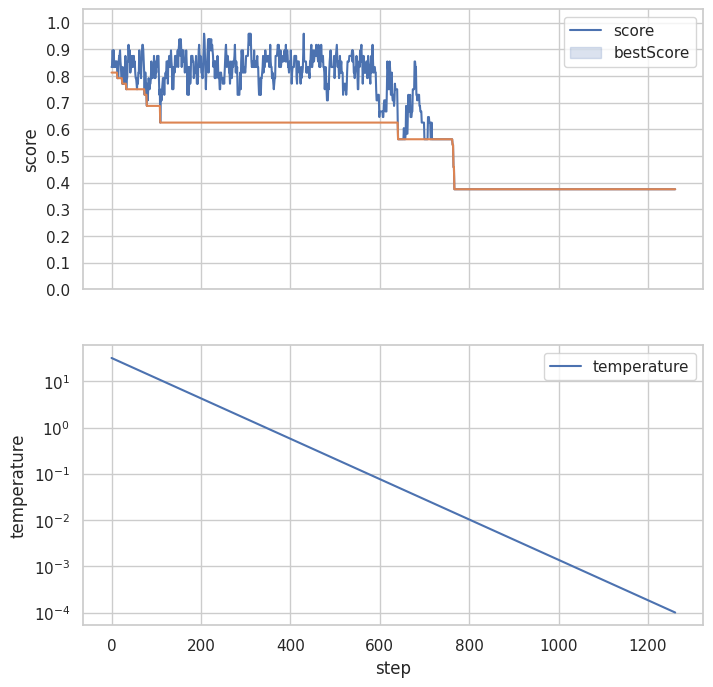

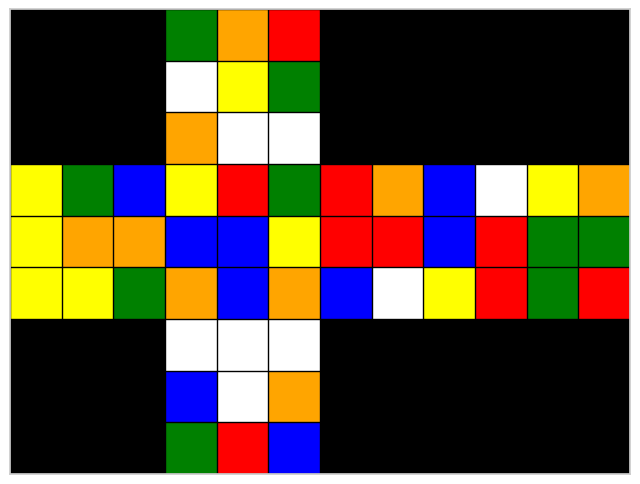

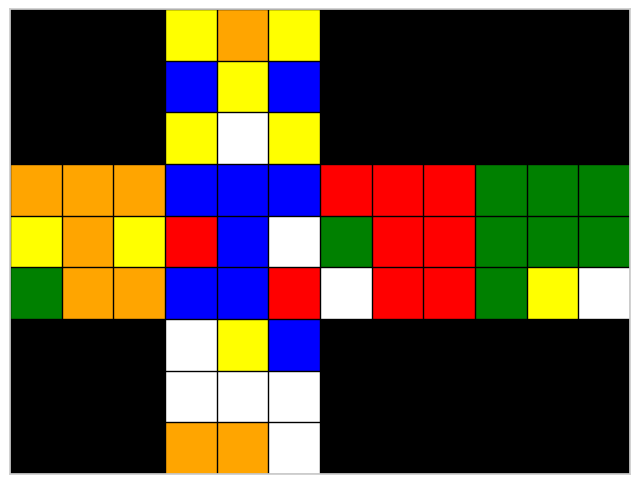

In [798]:
maxReductionILocIndex = expDF["resultBestScore"].argmin()
maxReductionSimulationProgressDF = expDF.iloc[[maxReductionILocIndex]]
display(maxReductionSimulationProgressDF[["initialTemperature", "beta", "initialScore", "resultBestScore"]])
maxReductionSimulationProgressDF = maxReductionSimulationProgressDF[["temperature", "bestScore", "score", "time"]]
maxReductionSimulationProgressDF = maxReductionSimulationProgressDF.explode(["temperature", "bestScore", "score"])
maxReductionSimulationProgressDF["step"] = list(range(maxReductionSimulationProgressDF.shape[0]))
fig, axes = plotSimulationProgress(maxReductionSimulationProgressDF)
axes[0].set_ylim((0,1.05))
axes[0].set_yticks([i/10 for i in range(0,11)])
initialCube = cubesSample[expDF.iloc[maxReductionILocIndex].name]["cube"]
bestState = expDF.iloc[maxReductionILocIndex]["resultBestState"]
print(bestState)
showCube(initialCube)
showCube(bestState[-1])

,initialTemperature,beta,initialScore,resultBestScore
cubeID,,,,
166,1024,0.95,0.8125,0.770833


[['U', "R'", "F'", 'B', 'D', 'U', "F'", 'R2', "L'", 'R2', 'D', 'D', 'R2', "B'", 'F', 'B2', "U'", 'U', 'F', 'R', "R'", 'F2', 'D2', 'D2', 'R2', "U'", 'F', 'R', "F'", "L'", 'B2', 'D', 'L', 'R2', 'B', "D'", 'L', "D'", 'U2', "U'", 'B2', 'F', 'L2', 'B', 'D2', 'L2', 'L', 'D2', 'L', 'U', "B'", "D'", 'R2', 'L2', "L'", "F'", 'D2', 'L', 'D2', 'B2', 'L2', "R'", "B'", 'D2', 'L', 'U2', 'B2', 'D2', 'D2', "B'", "R'", "R'", 'L', "U'", 'B2', 'D2', 'F2', 'F2', 'D', 'L2', 'F2', "F'", "F'", 'L2', "B'", 'D', "B'", 'F2', 'U', "D'", 'D', 'D', 'D2', 'F', 'R', 'D', "L'", 'U2', 'B', 'R', 'B', 'D2', 'L', "U'", "F'", 'F', "L'", 'L', 'U', 'U2', "D'", 'L2', 'F', "F'", 'F', 'B2', "U'", 'F2', 'B2', "L'", "D'", 'F', 'U2', 'U', "U'", "U'", 'B2', 'R2', 'L', 'R2', 'U', 'B', "R'", "L'", "U'", "D'", 'B', "R'", "B'", 'R2', 'U2', 'L', 'F', "U'", 'D', 'L2', 'R2', 'D2', 'L', 'R', "D'", 'U', "D'", 'L2', 'R2', "U'", 'L2', 'U2', "U'", 'B2', 'L2', "F'", 'R2', 'U', "L'", "U'", "B'", 'F', 'D', "D'", "D'", 'B', 'L2', 'U2', 'D', 'L2', 

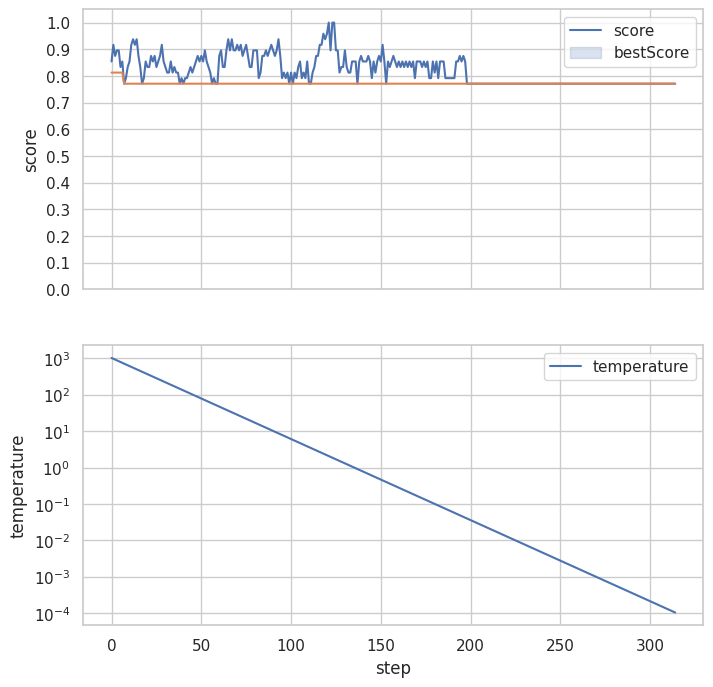

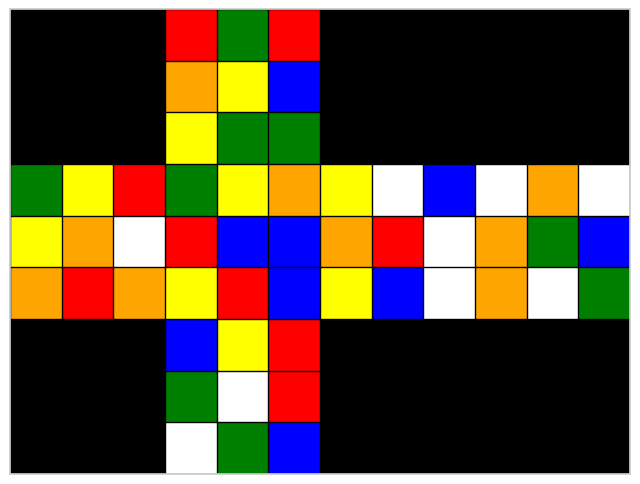

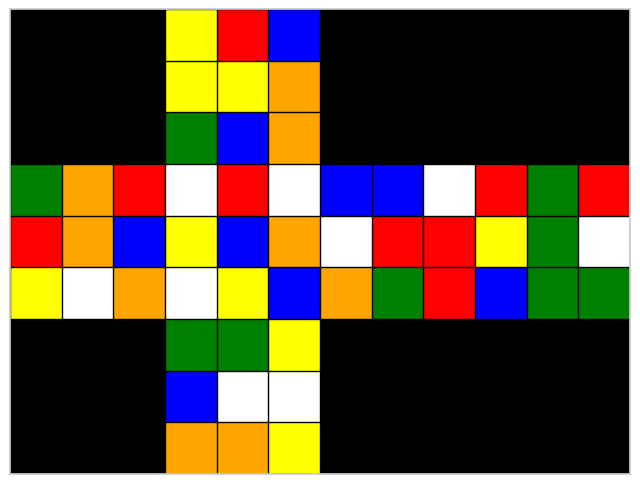

In [799]:
minReductionILocIndex = expDF["resultBestScore"].argmax()
minReductionSimulationProgressDF = expDF.iloc[[minReductionILocIndex]]
display(minReductionSimulationProgressDF[["initialTemperature", "beta", "initialScore", "resultBestScore"]])
minReductionSimulationProgressDF = minReductionSimulationProgressDF[["temperature", "bestScore", "score", "time"]]
minReductionSimulationProgressDF = minReductionSimulationProgressDF.explode(["temperature", "bestScore", "score"])
minReductionSimulationProgressDF["step"] = list(range(minReductionSimulationProgressDF.shape[0]))
fig, axes = plotSimulationProgress(minReductionSimulationProgressDF)
axes[0].set_ylim((0,1.05))
axes[0].set_yticks([i/10 for i in range(0,11)])
initialCube = cubesSample[expDF.iloc[minReductionILocIndex].name]["cube"]
bestState = expDF.iloc[minReductionILocIndex]["resultBestState"]
print(bestState)
showCube(initialCube)
showCube(bestState[-1])

## **Experiment 8**

- States are movement sequences
- Transitions correspond to a single movement out of the 19 allowed movements (it is possible to undo the last movement)
- Energy function represents the number of incorrect cubies

In [800]:
experimentName = "exp8"

In [801]:
neighborsFunctionExp = sequentialMovementNeighbors
def utilityFunctionExp(state, **kwargs):
    movements = state[0]
    cube = state[3]
    return weightedWrongPlacedCubies(cube, normalize = True)

In [802]:
# Uncomment the lines below if you need to run the experiment again
resultsExp = []
for sequenceLength in [128, 256, 512, 1024]:
    results = runExperiment(
        cubesSample,
        simulatedAnnealingHyperparameters, 
        neighborsFunctionExp, 
        utilityFunctionExp,
        initialState = [[], 0, sequenceLength],
        verbose = False
    )
    resultsExp.append({"sequenceLength": sequenceLength, "results": results})

with open(f"{cubesSampleDir}/{experimentName}-results.pkl", "wb") as f:
    pkl.dump(resultsExp, f)

resultsFile = open(f"{cubesSampleDir}/{experimentName}-results.pkl", "rb")
resultsExp = pkl.load(resultsFile)
resultsFile.close()

100%|██████████| 200/200 [11:15<00:00,  3.38s/it]


In [803]:
expDF = []
for results in resultsExp:
    expDF.append(processExperimentResults(results["results"]))
    expDF[-1]["movementSequenceLength"] = results["sequenceLength"]
expDF = pd.concat(expDF)
print(expDF.shape)
expDF.head(1)

(14400, 14)


,initialTemperature,simulationSteps,tolerance,annealingStrat,beta,initialScore,resultBestState,resultBestScore,temperature,score,bestScore,time,transitionSequence,movementSequenceLength
cubeID,,,,,,,,,,,,,,
0,1024,1,0.0001,exponential,0.995,1.0,"[[R2, R', B', R2, R, F', U', F, R, B, R, R', D...",0.75,"[1024, 1018.88, 1013.7856, 1008.716672, 1003.6...","[0.85, 1.0, 1.0, 1.0, 1.0, 0.95, 0.95, 1.0, 1....","[0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.8...",0.15333,"[R2, R', B', R2, R, F', U', F, R, B, R, R', D,...",128


(0.0, 1.0)

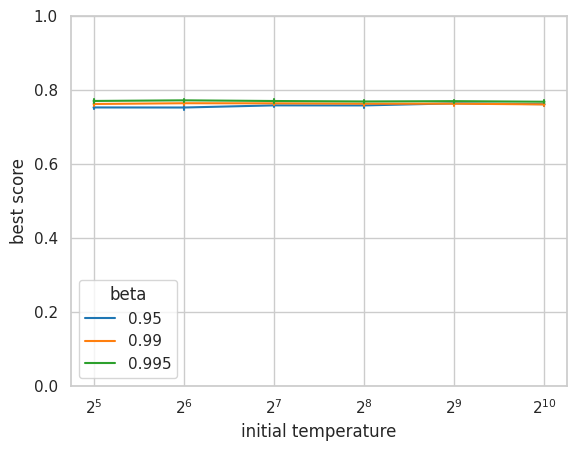

In [805]:
plotBestScoreByHyperparameters(expDF)
plt.ylim(0,1)

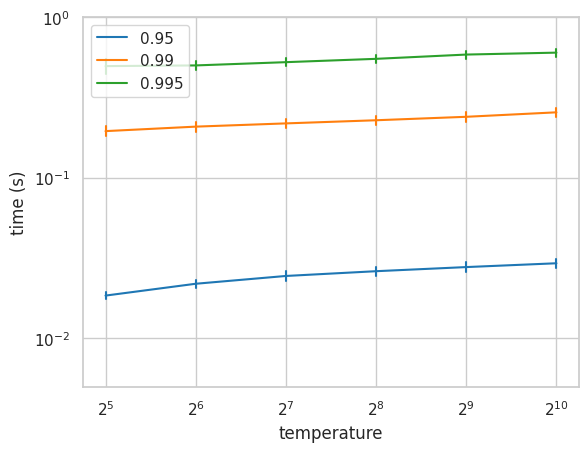

In [807]:
plotTimeByHyperparameters(expDF)
plt.yscale("log")
plt.ylim((0.005, 1))
plt.legend(loc = "upper left")

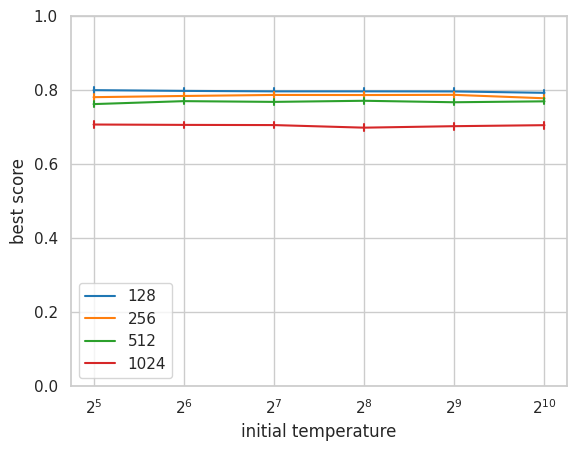

In [808]:
plotBestScoreByMovementSequenceLength(expDF)
plt.ylim(0,1)
plt.legend(loc = "lower left")

,initialTemperature,beta,initialScore,resultBestScore
cubeID,,,,
21,512,0.95,1.0,0.55


[['R', 'U2', "R'", "R'", 'B', 'U2', 'R', 'F2', 'L', 'B2', "D'", 'L2', "L'", 'B', 'L', 'B2', "U'", 'D', 'U', 'F', "D'", "D'", 'U2', "R'", 'L2', 'D', "L'", "L'", 'R', "L'", "U'", 'U2', "F'", "D'", 'L2', "U'", 'B2', 'U', 'D2', 'B', 'D', "U'", "B'", 'F2', "L'", 'L', 'F', 'R2', 'R', 'U', "D'", 'U', 'B2', "B'", 'D2', "F'", 'D', "B'", "L'", "R'", 'U2', "D'", 'U', "U'", "B'", "B'", 'B', 'B', 'D2', 'L2', "L'", 'F2', 'R2', 'L', "R'", 'D2', "U'", 'L', 'F', "F'", 'R', 'L', "R'", 'B', 'U', 'B2', "L'", 'L2', "F'", 'F2', 'B', 'U', "R'", 'B2', "L'", 'D', 'B', 'L2', "L'", 'U', "U'", "F'", "B'", 'U', 'D', 'U2', 'F', 'L', "B'", "B'", 'L2', 'D2', 'B2', 'B2', 'F', "D'", 'L2', 'D2', 'F', "F'", "D'", 'L2', 'L', "D'", 'U', "F'", 'R', 'R', "F'", 'L2', "B'", 'U', 'L2', "B'", 'D2', 'R', 'D2', "B'", 'L', "B'", 'B', 'D', "D'", 'B', 'F', 'F', 'L', "B'", "D'", "B'", "F'", 'L', "U'", 'U', "B'", "R'", 'L', 'F2', 'D2', 'F2', 'D', 'B2', 'B', 'F2', "F'", 'D', 'U', "U'", 'F', "U'", 'U2', 'R', 'R', 'B', 'R', 'F', 'U2', 'F2

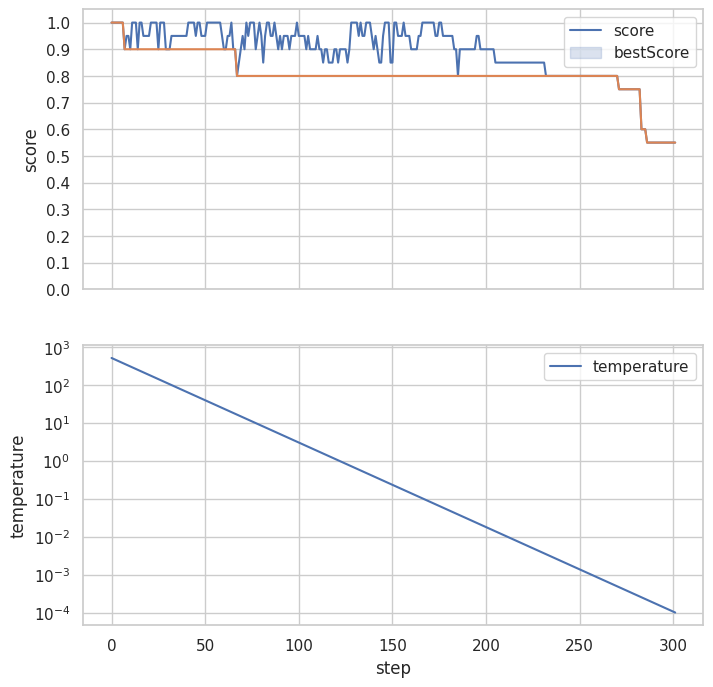

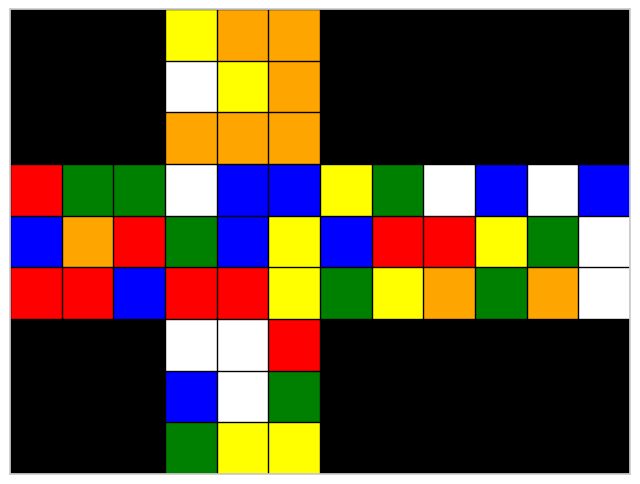

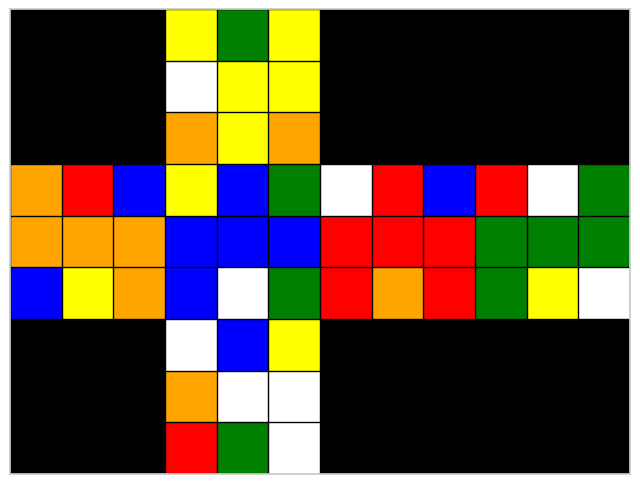

In [810]:
maxReductionILocIndex = expDF["resultBestScore"].argmin()
maxReductionSimulationProgressDF = expDF.iloc[[maxReductionILocIndex]]
display(maxReductionSimulationProgressDF[["initialTemperature", "beta", "initialScore", "resultBestScore"]])
maxReductionSimulationProgressDF = maxReductionSimulationProgressDF[["temperature", "bestScore", "score", "time"]]
maxReductionSimulationProgressDF = maxReductionSimulationProgressDF.explode(["temperature", "bestScore", "score"])
maxReductionSimulationProgressDF["step"] = list(range(maxReductionSimulationProgressDF.shape[0]))
fig, axes = plotSimulationProgress(maxReductionSimulationProgressDF)
axes[0].set_ylim((0,1.05))
axes[0].set_yticks([i/10 for i in range(0,11)])
initialCube = cubesSample[expDF.iloc[maxReductionILocIndex].name]["cube"]
bestState = expDF.iloc[maxReductionILocIndex]["resultBestState"]
print(bestState)
showCube(initialCube)
showCube(bestState[3])

,initialTemperature,beta,initialScore,resultBestScore
cubeID,,,,
2,1024,0.95,1.0,0.9


[['R2', "R'", "B'", 'R2', 'R', "F'", "U'", 'F', 'R', 'B', 'R', "R'", 'D', 'F', "L'", 'R', "F'", 'D', 'F2', 'U', "D'", 'L', 'D', 'L', 'D2', 'B', "F'", "F'", 'D2', 'F', "F'", 'U2', 'B2', 'R2', 'F', "R'", 'R2', "F'", 'U', 'B2', "D'", "B'", "L'", 'B', "D'", 'U', "L'", 'U2', 'B', 'U', 'D', 'F', "R'", 'R', 'U2', "B'", "F'", "D'", "F'", 'U2', 'B2', 'D', 'R', 'L', "F'", 'B2', "B'", 'F', 'R', "D'", 'B2', 'B2', 'U', 'F', 'R', 'L', "D'", 'L', "F'", "B'", 'B2', "F'", 'U', 'F2', 'F2', 'L', "R'", "F'", 'D', "B'", 'U', 'L', 'D2', "U'", "R'", "L'", 'F2', 'R', "R'", "B'", "D'", 'R', 'U', "D'", "R'", 'R', 'D', 'B', "F'", 'F2', 'D', 'R', "R'", 'F2', 'F', 'D', "U'", 'L', 'L2', "F'", 'B', 'D2', 'D2', "B'", "L'", "F'", 'R2', "U'", 'D', 'F2', 'R2', 'L', 'D', "F'", 'U2', "B'", 'R2', 'L', 'R2', 'B', "B'", "F'", 'U', 'F', "R'", 'D2', 'F', 'D2', "B'", "D'", "F'", "B'", "B'", "F'", 'D', 'L2', "L'", "D'", "F'", 'F2', 'R2', 'L2', "R'", "R'", 'B2', 'D2', 'R', 'B2', "R'", "U'", 'F2', 'D2', 'U', 'R2', 'B2', 'D2', "F'"

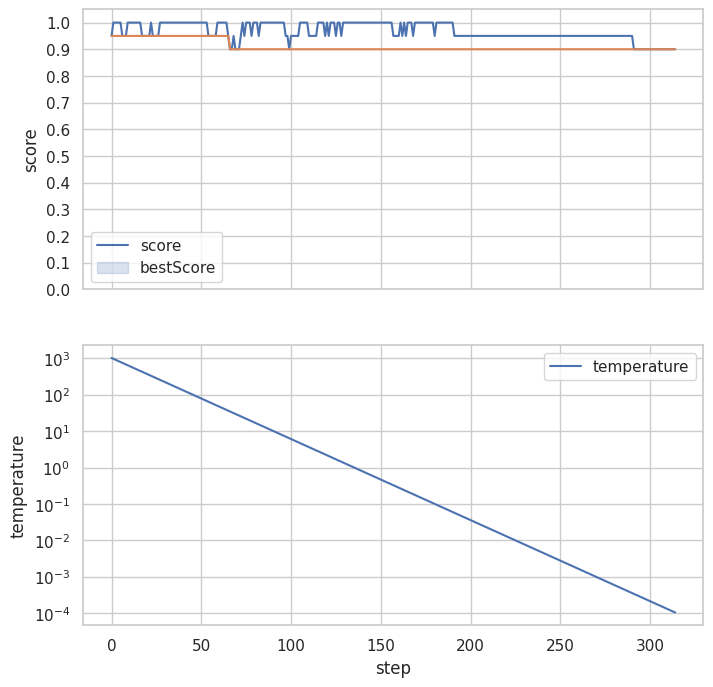

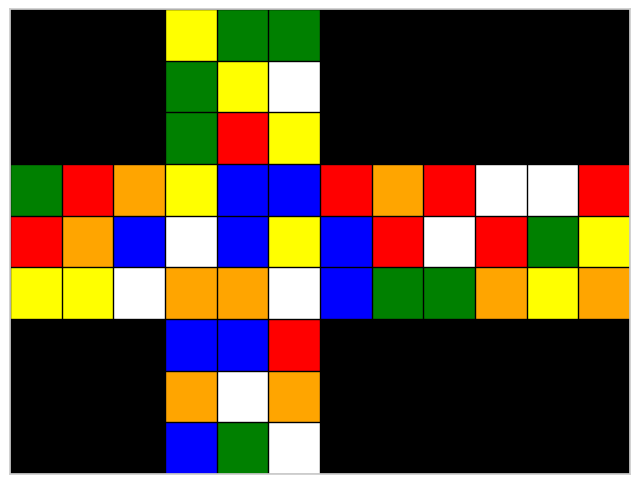

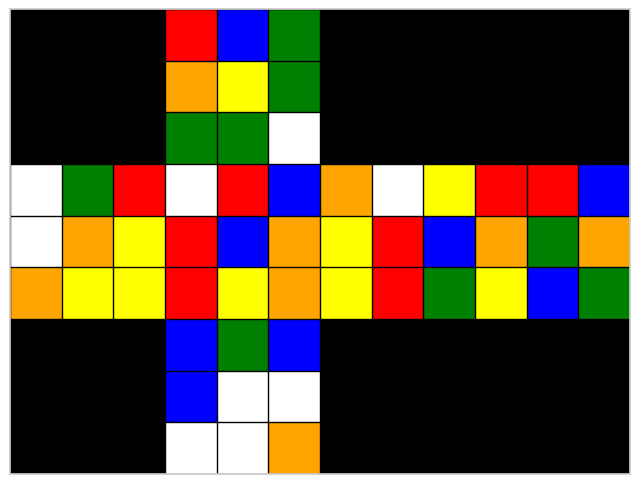

In [811]:
minReductionILocIndex = expDF["resultBestScore"].argmax()
minReductionSimulationProgressDF = expDF.iloc[[minReductionILocIndex]]
display(minReductionSimulationProgressDF[["initialTemperature", "beta", "initialScore", "resultBestScore"]])
minReductionSimulationProgressDF = minReductionSimulationProgressDF[["temperature", "bestScore", "score", "time"]]
minReductionSimulationProgressDF = minReductionSimulationProgressDF.explode(["temperature", "bestScore", "score"])
minReductionSimulationProgressDF["step"] = list(range(minReductionSimulationProgressDF.shape[0]))
fig, axes = plotSimulationProgress(minReductionSimulationProgressDF)
axes[0].set_ylim((0,1.05))
axes[0].set_yticks([i/10 for i in range(0,11)])
initialCube = cubesSample[expDF.iloc[minReductionILocIndex].name]["cube"]
bestState = expDF.iloc[minReductionILocIndex]["resultBestState"]
print(bestState)
showCube(initialCube)
showCube(bestState[3])

## **Experiment 9**

- States are movement sequences
- Transitions correspond to a single movement out of the 19 allowed movements (it is possible to undo the last movement)
- Energy function represents the number of incorrect cubie pairs

In [813]:
experimentName = "exp9"

In [814]:
neighborsFunctionExp = sequentialMovementNeighbors
def utilityFunctionExp(state, **kwargs):
    movements = state[0]
    cube = state[3]
    return wrongCubiePairs(cube, normalize = True)

In [815]:
# Uncomment the lines below if you need to run the experiment again
# resultsExp = []
# for sequenceLength in [128, 256, 512, 1024]:
#     results = runExperiment(
#         cubesSample,
#         simulatedAnnealingHyperparameters, 
#         neighborsFunctionExp, 
#         utilityFunctionExp,
#         initialState = [[], 0, sequenceLength],
#         verbose = False
#     )
#     resultsExp.append({"sequenceLength": sequenceLength, "results": results})

# with open(f"{cubesSampleDir}/{experimentName}-results.pkl", "wb") as f:
#     pkl.dump(resultsExp, f)

resultsFile = open(f"{cubesSampleDir}/{experimentName}-results.pkl", "rb")
resultsExp = pkl.load(resultsFile)
resultsFile.close()

  1%|          | 2/200 [00:44<1:12:52, 22.08s/it]

In [ ]:
expDF = []
for results in resultsExp:
    expDF.append(processExperimentResults(results["results"]))
    expDF[-1]["movementSequenceLength"] = results["sequenceLength"]
expDF = pd.concat(expDF)
print(expDF.shape)
expDF.head(1)

(14400, 14)


,initialTemperature,simulationSteps,tolerance,annealingStrat,beta,initialScore,resultBestState,resultBestScore,temperature,score,bestScore,time,transitionSequence,movementSequenceLength
cubeID,,,,,,,,,,,,,,
0,1024,1,0.0001,exponential,0.995,1.0,"[[R2, R', B', R2, R, F', U', F, R, B, R, R', D...",0.75,"[1024, 1018.88, 1013.7856, 1008.716672, 1003.6...","[0.85, 1.0, 1.0, 1.0, 1.0, 0.95, 0.95, 1.0, 1....","[0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.8...",0.15333,"[R2, R', B', R2, R, F', U', F, R, B, R, R', D,...",128


(0.0, 1.0)

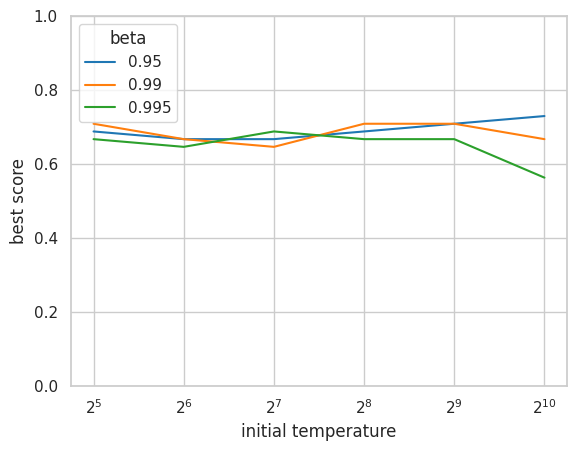

In [ ]:
plotBestScoreByHyperparameters(expDF)
plt.ylim(0,1)

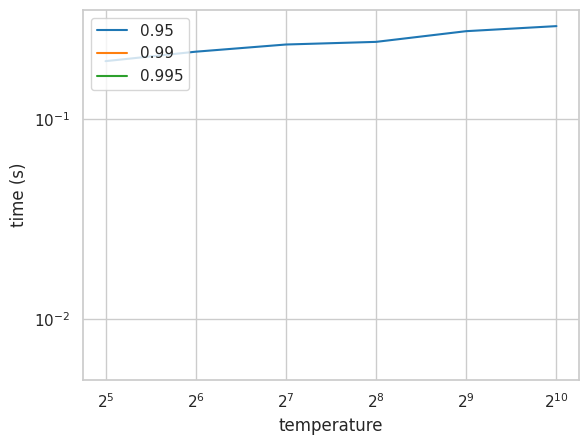

In [ ]:
plotTimeByHyperparameters(expDF)
plt.yscale("log")
plt.ylim((0.005, 0.35))
plt.legend(loc = "upper left")

In [ ]:
plotBestScoreByMovementSequenceLength(expDF)
plt.ylim(0,1)
plt.legend(loc = "lower left")

,initialTemperature,beta,initialScore,resultBestScore
cubeID,,,,
0,1024,0.995,0.8125,0.5625


U R' D' R B R D F2 L F L2 U2 U B L D2 U' L' B' F U2 U' F' F R2 R L2 U' L' D R D R' B R D' D' D' U2 L B' F' F U2 R L B' L2 D2 L2 U' D' B F' D' U2 F2 L U2 B2 L2 L L' L R' B' F U B2 U L' B R D R2 L' D2 B' U' R U' L' D' B2 R2 D2 F' B U L F F' D U' U' D2 U B R2 F


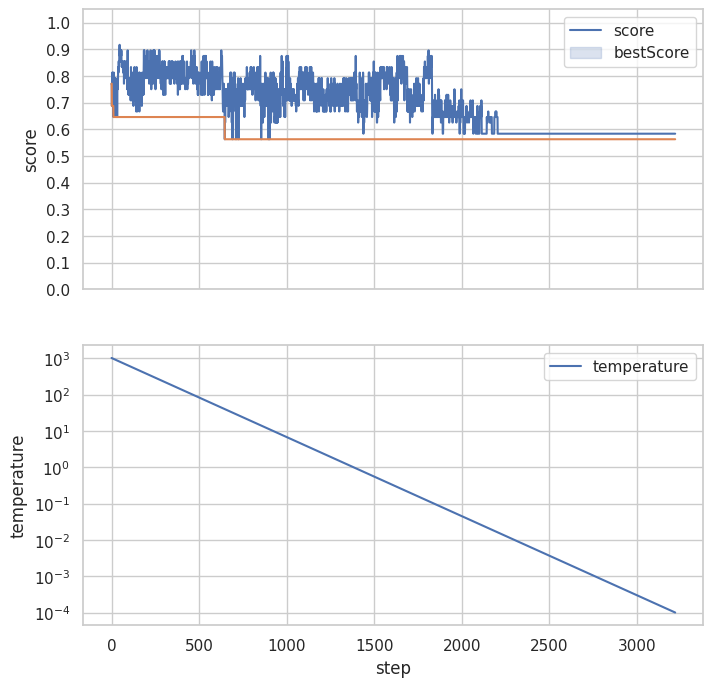

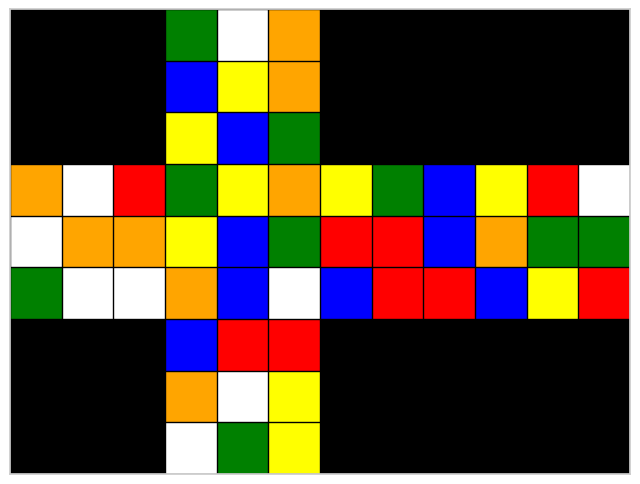

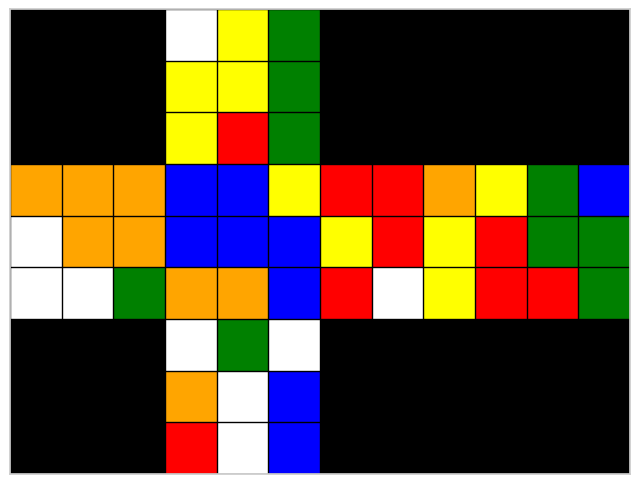

In [ ]:
maxReductionILocIndex = expDF["resultBestScore"].argmin()
maxReductionSimulationProgressDF = expDF.iloc[[maxReductionILocIndex]]
display(maxReductionSimulationProgressDF[["initialTemperature", "beta", "initialScore", "resultBestScore"]])
maxReductionSimulationProgressDF = maxReductionSimulationProgressDF[["temperature", "bestScore", "score", "time"]]
maxReductionSimulationProgressDF = maxReductionSimulationProgressDF.explode(["temperature", "bestScore", "score"])
maxReductionSimulationProgressDF["step"] = list(range(maxReductionSimulationProgressDF.shape[0]))
fig, axes = plotSimulationProgress(maxReductionSimulationProgressDF)
axes[0].set_ylim((0,1.05))
axes[0].set_yticks([i/10 for i in range(0,11)])
initialCube = cubesSample[expDF.iloc[maxReductionILocIndex].name]["cube"]
bestState = expDF.iloc[maxReductionILocIndex]["resultBestState"]
print(bestState)
showCube(initialCube)
showCube(bestState[3])

,initialTemperature,beta,initialScore,resultBestScore
cubeID,,,,
0,1024,0.95,0.8125,0.729167


U R' B D' B' R2 R' L2 U2 B' U R2 D2 F U' B F2 R' D' U B2 F2 R2 U2 F D2 U' B L2 U2 B2 L2 F B2 F2 U' U2 R U F' R F' R F2 D D F2 D2 F R2 D2 F2 L2 F' F D F' B R2 U U2 U2 F B' R2 B' B B' L2 U2 F2 B' R' B2 F2 X X X X X X X X X X X X X X X X X X X X X X X X X


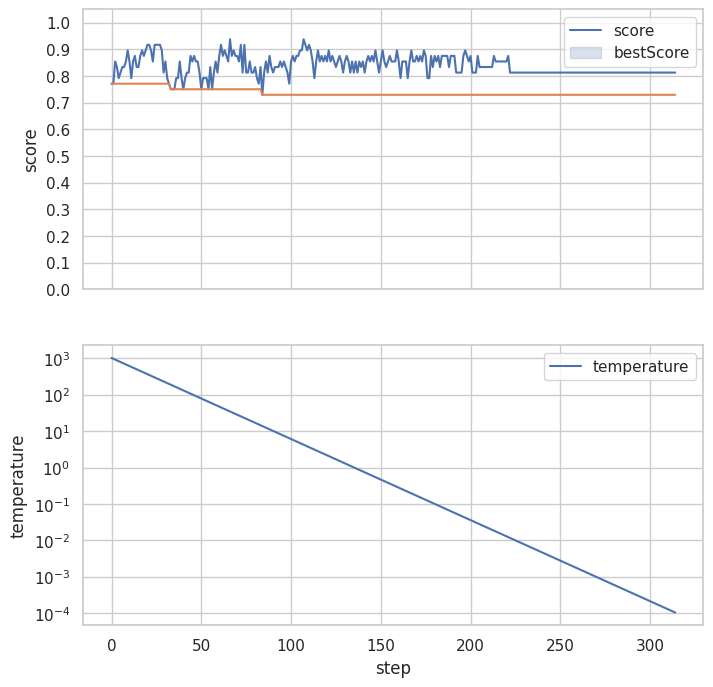

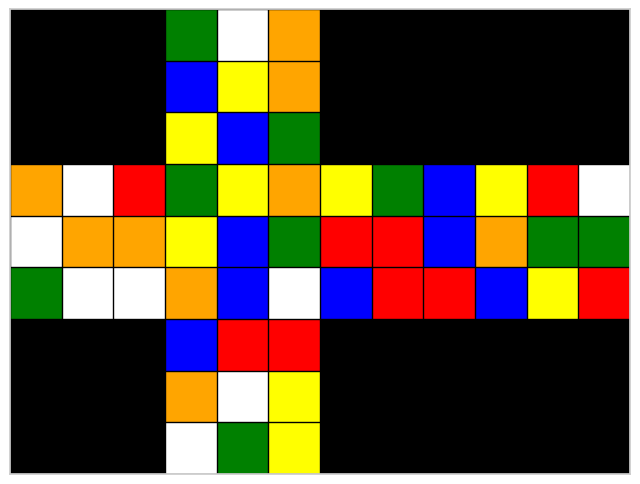

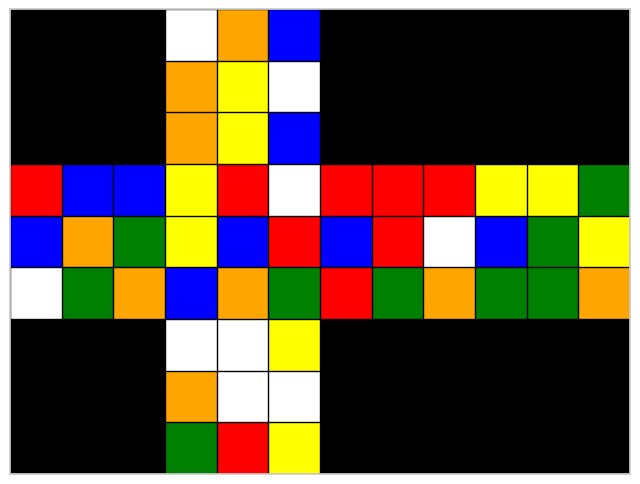

In [ ]:
minReductionILocIndex = expDF["resultBestScore"].argmax()
minReductionSimulationProgressDF = expDF.iloc[[minReductionILocIndex]]
display(minReductionSimulationProgressDF[["initialTemperature", "beta", "initialScore", "resultBestScore"]])
minReductionSimulationProgressDF = minReductionSimulationProgressDF[["temperature", "bestScore", "score", "time"]]
minReductionSimulationProgressDF = minReductionSimulationProgressDF.explode(["temperature", "bestScore", "score"])
minReductionSimulationProgressDF["step"] = list(range(minReductionSimulationProgressDF.shape[0]))
fig, axes = plotSimulationProgress(minReductionSimulationProgressDF)
axes[0].set_ylim((0,1.05))
axes[0].set_yticks([i/10 for i in range(0,11)])
initialCube = cubesSample[expDF.iloc[minReductionILocIndex].name]["cube"]
bestState = expDF.iloc[minReductionILocIndex]["resultBestState"]
print(bestState)
showCube(initialCube)
showCube(bestState[3])

In [19]:
cube = createSolvedCube()

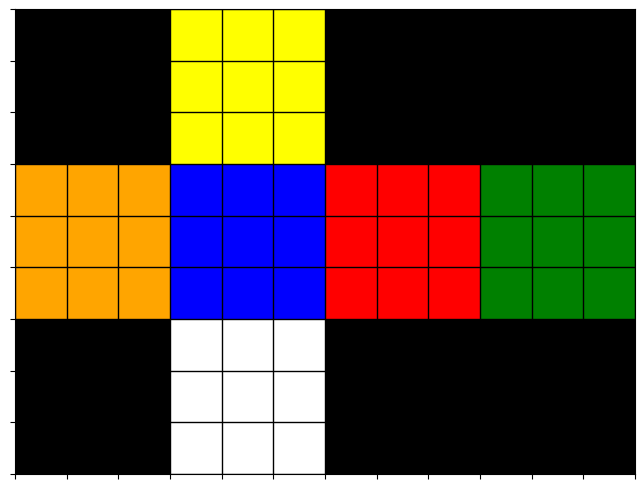

In [20]:
showCube(cube)

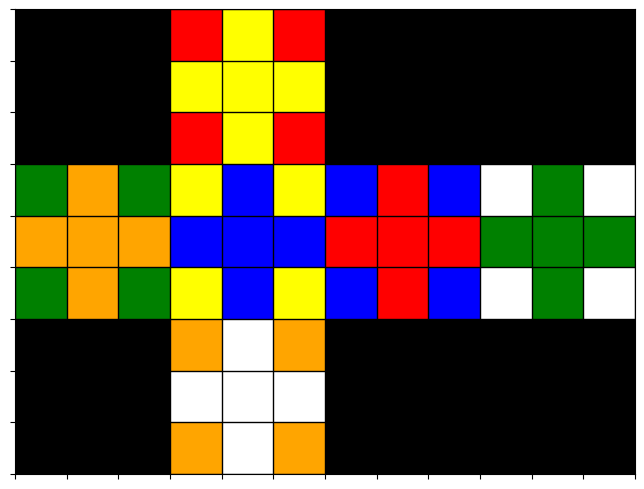

In [21]:
showCube(turn(cube, movements = "R2 L' D F2 R' D' R' L U' D R D B2 R' U D2"))

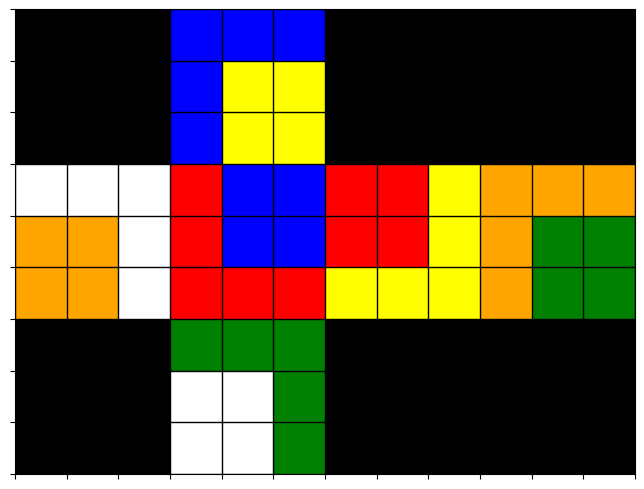

In [22]:
showCube(turn(cube, movements = "F L F U' R U F2 L2 U' L' B D' B' L2 U"))

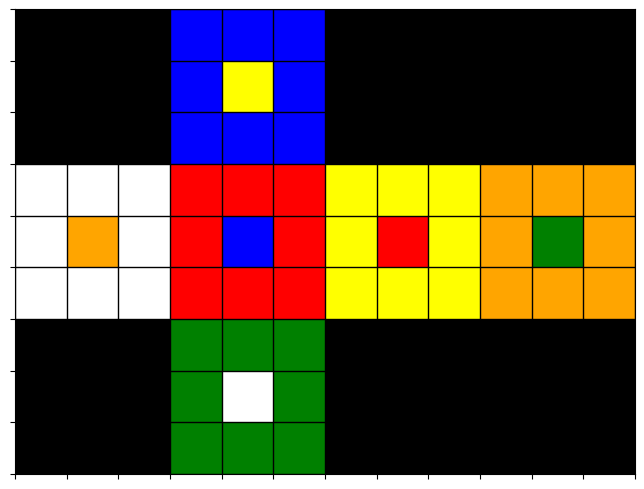

In [23]:
showCube(turn(cube, movements = "U D' R L' F B' U D'"))